# Workshop Attribute and Spatial Data Operations

## 1. Introduction

In this workshop, we will explore the concepts and techniques presented in: [Attribute Data Operations](https://py.geocompx.org/02-attribute-operations) and [Spatial Operations](https://py.geocompx.org/03-spatial-operations) from the book **"Geocomputation with Python"**. These sections cover basic operations for spatial analysis, combining vector, raster, and tabular (attribute) data.

The primary goal of this workshop is to become familiar with fundamental and advanced operations on spatial data (both raster and vector) and their associated attributes using **Python**. 

In this workshop you need to use data associated to your course project.

## 2. Required Data

To complete this workshop, each group must use the following type of datasets associated to your own course project:

### 2.1. Vector Data

Geospatial data in Shapefile format will be used, including administrative boundaries such as municipalities, as well as other relevant polygons like double drainages and land use coverages. Line data corresponding to roads will also be included.

### 2.2. Raster Data

### 2.3. Tabular Data

Tabular data with attributes for vector layers will be used, primarily consisting of inputs on conflict-affected population data associated with administrative boundaries.

## 5. Activities

### 5.1. Attribute Data Operations 

Filter entities based on specific attributes (e.g., select  dryland forests within the municipality of Puerto Gaitán that are close to roads).

Número de bosques en Puerto Gaitán cercanos a carreteras: 421


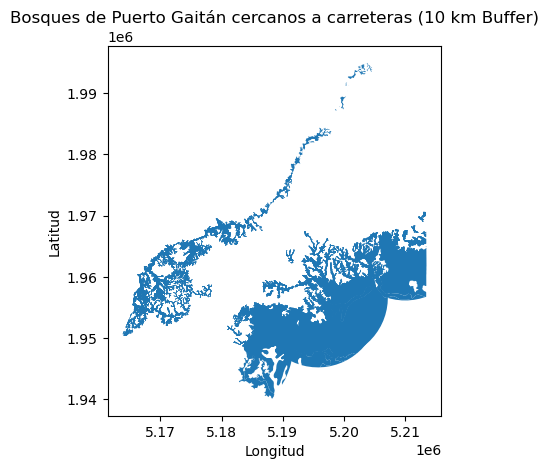

In [118]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar las capas necesarias
carreteras = gpd.read_file("Data\\Via.shp")
coberturas = gpd.read_file("Data\\Coberturas.shp") 
municipios = gpd.read_file("Data\\Municipios.shp")

# Filtrar el municipio de Puerto Gaitán usando .loc() para aplicar condiciones
puerto_gaitan = municipios.loc[municipios["MpNombre"] == "Puerto Gaitan"]

# Filtrar las coberturas dentro del municipio de Puerto Gaitán
coberturas_pg = gpd.overlay(coberturas, puerto_gaitan, how="intersection", keep_geom_type=True)

# Crear un buffer de 10 km alrededor de las carreteras
carreteras_buffer = carreteras.buffer(10000)

# Convertir el buffer de carreteras a GeoDataFrame
carreteras_buffer_gdf = gpd.GeoDataFrame(geometry=carreteras_buffer, crs=carreteras.crs)

# Intersectar el buffer de las carreteras con las coberturas del municipio de Puerto Gaitán
coberturas_cercanas_carreteras = gpd.overlay(coberturas_pg, carreteras_buffer_gdf, how="intersection", keep_geom_type=True)

# Filtrar las coberturas que correspondan a bosques utilizando múltiples condiciones
bosques_pg_cercanos_carreteras = coberturas_cercanas_carreteras.loc[coberturas_cercanas_carreteras["nivel_3"] == "311"]

# Mostrar la salida de los resultados obtenidos
print(f"Número de bosques en Puerto Gaitán cercanos a carreteras: {len(bosques_pg_cercanos_carreteras)}")

# Visualizar el resultado en un gráfico (opcional)
bosques_pg_cercanos_carreteras.plot()
plt.title("Bosques de Puerto Gaitán cercanos a carreteras (10 km Buffer)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

Group data by a categorical attribute (e.g., land use type) and summarise other attributes like area or population.

In [119]:
import geopandas as gpd
import pandas as pd

# 1. Cargar las capas necesarias
coberturas = gpd.read_file("Data\\Coberturas.shp")
municipios = gpd.read_file("Data\\Municipios.shp") 
poblacion_victima = pd.read_csv("Data\\Víctimas_por_hecho_victimizante_por_año_Corte_DICIEMBRE_DE_2024.csv", sep=";")

# 2. Verificar y reproyectar las capas a un sistema proyectado adecuado
coberturas = coberturas.to_crs(epsg=9377)
municipios = municipios.to_crs(epsg=9377)

# 3. Intersección de las coberturas con los municipios
coberturas_municipios = gpd.overlay(coberturas, municipios, how="intersection", keep_geom_type=False)

# 4. Calcular el área en hectáreas para cada polígono resultante
coberturas_municipios["area_ha"] = coberturas_municipios.geometry.area / 10_000

# 5. Asegurarse de que las claves de unión sean del mismo tipo
coberturas_municipios["MpCodigo"] = coberturas_municipios["MpCodigo"].astype(str)
poblacion_victima["COD_CIUDAD_MUNI"] = poblacion_victima["COD_CIUDAD_MUNI"].astype(str)

# 6. Unir la tabla de población víctima del conflicto armado
coberturas_municipios = coberturas_municipios.merge(poblacion_victima, left_on="MpCodigo", right_on="COD_CIUDAD_MUNI", how="left")

# 7. Agrupar por tipo de uso de suelo y resumir atributos (población total y área promedio)
resumen = coberturas_municipios.groupby("MpNombre").agg(
    Poblacion_Victima=("EVENTOS", "sum"),
    Coberturas_Area=("nivel_3", lambda x: list(x.unique()))
).reset_index()

# 9. Mostrar el resumen de los resultados
print(resumen)

        MpNombre  Poblacion_Victima  \
0       Cumaribo              98268   
1      Mapiripan              20230   
2  Puerto Gaitan             676753   

                                     Coberturas_Area  
0  [321, 311, 323, 313, 314, 244, 511, 231, 242, ...  
1      [314, 244, 323, 313, 311, 231, 243, 242, 511]  
2  [314, 231, 311, 242, 511, 321, 243, 323, 313, ...  


Merge geometries and summarise data by a grouping attribute (e.g., dissolve administrative boundaries into regions).

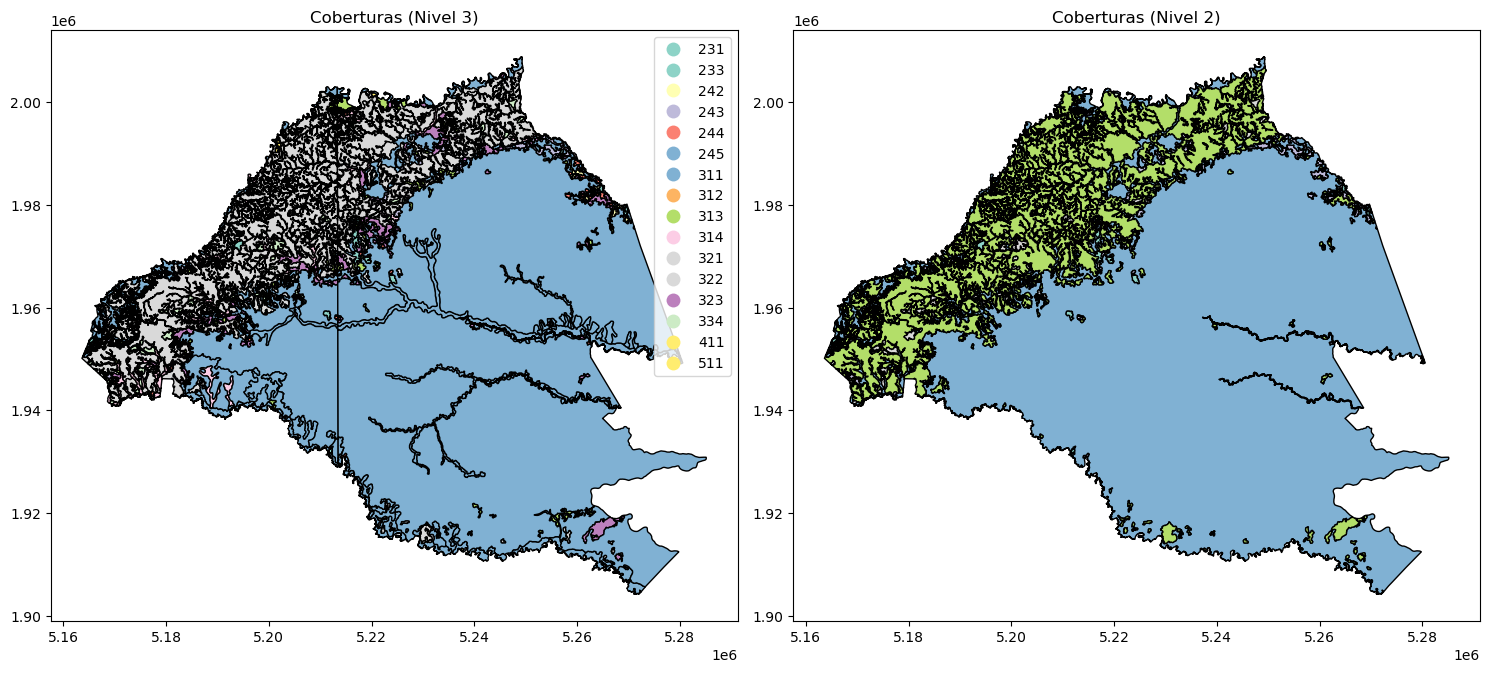

     nivel_3      area_ha
0        314     0.162519
1        314     0.162519
2        314     0.162519
3        314     0.162519
4        314     0.162519
...      ...          ...
1664     511  1624.574551
1665     511  1624.574551
1666     511  1624.574551
1667     511  1624.574551
1668     511  1624.574551

[1669 rows x 2 columns]
  nivel_2           area
0      23    2075.625801
1      24    7010.664477
2      31  511168.852511
3      32  146227.944176
4      33    4535.618994
5      41     170.382561
6      51    2117.361356


In [120]:
import geopandas as gpd
import pandas as pd

# 1. Cargar las capas necesarias
coberturas = gpd.read_file("Data\\Coberturas.shp")
municipios = gpd.read_file("Data\\Municipios.shp")

nivel_2 = coberturas.dissolve(by='nivel_2')

nivel_2['area'] = nivel_2.geometry.area/10_000

# 4. Restablecer el índice para acceder a la columna 'nivel_2' fácilmente
nivel_2 = nivel_2.reset_index()

# Crear una figura y un conjunto de subgráficos
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Mostrar la capa de municipios en el primer subgráfico
coberturas.plot(ax=ax[0], column='nivel_3', legend=True, cmap='Set3', edgecolor='black')
ax[0].set_title('Coberturas (Nivel 3)')

# Mostrar la capa disuelta por departamentos en el segundo subgráfico
nivel_2.plot(ax=ax[1], legend=True, cmap='Set3', edgecolor='black')
ax[1].set_title('Coberturas (Nivel 2)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

print(coberturas[['nivel_3', 'area_ha']])
print(nivel_2[['nivel_2', 'area']])

### 5.2. Spatial Operations

#### 5.2.1. Spatial Relationships and Selection

##### 1. Select entities based on their spatial relationship: e.g.  Identify urban areas within a conservation zone.

###### Solución

Se van a seleccionar vías que están en el municipio de Puerto Gaitán. Para ello, se cargan los archivos shapefile de las carreteras y los municipios:

In [121]:
import geopandas as gpd

carreteras = gpd.read_file("Data\\Via.shp")
municipios = gpd.read_file("Data\\Municipios.shp")

Filtrar el municipio de Puerto Gaitán a partir de la columna 'MpNombre'. Esto selecciona únicamente el municipio que tiene el nombre 'Puerto Gaitan' en la columna correspondiente: 

In [122]:
Puerto_Gaitan = municipios[municipios['MpNombre'] == 'Puerto Gaitan']
Puerto_Gaitan

FID_Limite MpCodigo       MpNombre        MpArea                   MpNorma  \
1        1500    50568  Puerto Gaitan  17199.254178  Ordenanza No. 39 de 1969   

   MpCategor  MpAltitud                                         Restriccio  \
1          1        149  “No es apropiada su aplicación para la ubicaci...   

  Depto     AREA_TOTAL                                           geometry  
1  Meta  186676.364946  POLYGON Z ((5213329.219 2002795.708 0, 5213509...

Comprobar qué carreteras intersectan con el municipio de Puerto Gaitán. Se usamos la función 'intersects' para verificar si las geometrías de las carreteras intersectan con la geometría de Puerto Gaitán (el primer elemento de la geometría de la capa de municipios): 

In [123]:
sel = carreteras.intersects(Puerto_Gaitan.geometry.iloc[0])
sel

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
dtype: bool

Filtrar solo las carreteras que intersectan con Puerto Gaitán. Se aplica el filtro utilizando el resultado de la operación 'intersects'

In [124]:
pg_vias = carreteras[sel]
pg_vias

TIPO_VIA ESTADO_SUP NUMERO_CAR ACCESIBILI NOMBRE_GEO PROYECTO SYMBOL  \
0          5       3306  Sin Valor       3601       None     None      2   
1          5       3306  Sin Valor       3601       None     None      2   
2          5       3306  Sin Valor       3601       None     None      2   
3          5       3306  Sin Valor       3601       None     None      2   
4          5       3306  Sin Valor       3601       None     None      2   
5          5       3306  Sin Valor       3601       None     None      2   
6          5       3306  Sin Valor       3601       None     None      2   
7          6       3350  Sin Valor       3601       None     None      2   
8          6       3350  Sin Valor       3601       None     None      2   
9          6       3350  Sin Valor       3601       None     None      2   
10         6       3350  Sin Valor       3601       None     None      2   
11         6       3350  Sin Valor       3601       None     None      2   
12         6       3350  Sin Valor       3601       None     None      2   
13         6       3350  Sin Valor       3601       None     None      2   
14         6       3350  Sin Valor       3601       None     None      2   
15         6       3350  Sin Valor       3601       None     None      2   
16         6       3350  Sin Valor       3601       None     None      2   
17         6       3350  Sin Valor       3601       None     None      2   

         FECHA     PK_CUE EJE_VIAL  \
0   0000/00/00  1974511.0     None   
1   0000/00/00  1974512.0     None   
2   0000/00/00  1974513.0     None   
3   0000/00/00  1975213.0     None   
4   0000/00/00  1975214.0     None   
5   0000/00/00  1975216.0     None   
6   0000/00/00  1975218.0     None   
7   0000/00/00  2073749.0     None   
8   0000/00/00  1975495.0     None   
9   0000/00/00  1975496.0     None   
10  0000/00/00  1974719.0     None   
11  0000/00/00  1974721.0     None   
12  0000/00/00  1974722.0     None   
13  0000/00/00  1974826.0     None   
14  0000/00/00  1974827.0     None   
15  0000/00/00  1974828.0     None   
16  0000/00/00  1974829.0     None   
17  0000/00/00  1975118.0     None   

                                             geometry  
0   LINESTRING Z (5189407.152 1956213.666 0, 51893...  
1   MULTILINESTRING Z ((5175345.87 1957827.731 0, ...  
2   LINESTRING Z (5180260.211 1946156.002 0, 51802...  
3   LINESTRING Z (5178547.569 1964804.049 0, 51784...  
4   MULTILINESTRING Z ((5188362.698 1967969.264 0,...  
5   MULTILINESTRING Z ((5211570.96 1971431.813 0, ...  
6   MULTILINESTRING Z ((5164088.743 1950284.637 0,...  
7   LINESTRING Z (5174916.466 1955638.205 0, 51748...  
8   MULTILINESTRING Z ((5173785.057 1962797.213 0,...  
9   LINESTRING Z (5169487.683 1960143.615 0, 51695...  
10  LINESTRING Z (5193077.54 1957402.897 0, 519316...  
11  LINESTRING Z (5164209.671 1949623.212 0, 51642...  
12  LINESTRING Z (5192503.407 1965933.694 0, 51925...  
13  LINESTRING Z (5188362.698 1967969.264 0, 51883...  
14  MULTILINESTRING Z ((5214268.73 1971008.53 0, 5...  
15  LINESTRING Z (5212330.321 1971634.379 0, 52125...  
16  LINESTRING Z (5210761.531 1982909.339 0, 52109...  
17  LINESTRING Z (5208057.399 1985614.752 0, 52078...

Visualización - Mapa original de los municipios con las carreteras. Primero, se dibuja el mapa de municipios con un borde gris claro y fondo blanco. Luego, sobreponemos las carreteras con color rojo para visualizarlas:

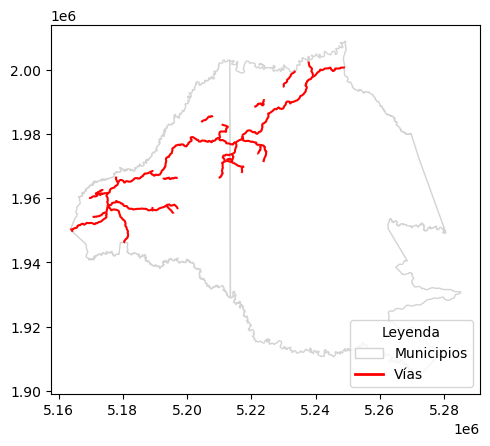

In [125]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

base = municipios.plot(color='white', edgecolor='lightgrey')
carreteras.plot(ax=base, color='red')

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Municipios'),
    Line2D([0], [0], color='red', lw=2, label='Vías')
]

# Agregar la leyenda con ambos elementos
plt.legend(handles=handles, title="Leyenda", loc='lower right')

Visualización - Mapa de la intersección entre las carreteras y Puerto Gaitán. Nuevamente, se dibuja el mapa de municipios pero ahora se destaca a Puerto Gaitán con un color gris claro. Sobre este, se visualizan las carreteras que intersectan con el municipio, coloreándolas de verde:

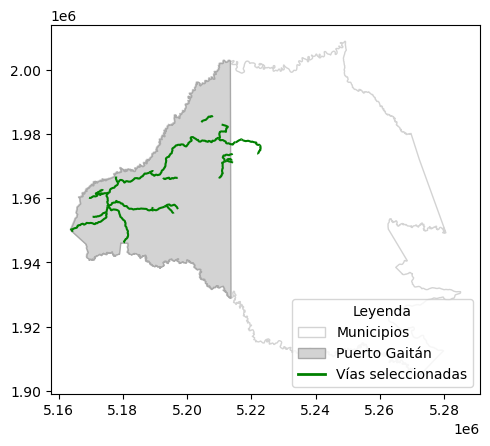

In [126]:
base = municipios.plot(color='white', edgecolor='lightgrey')
Puerto_Gaitan.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
pg_vias.plot(ax=base, color='green')


# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Municipios'),
    Patch(facecolor='lightgrey', edgecolor='darkgrey', label='Puerto Gaitán'),
    Line2D([0], [0], color='green', lw=2, label='Vías seleccionadas')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower right')

##### 2. Identify entities that intersect with another layer. e.g. Rivers intersecting with hazard zones.

###### Solución

Se identifican vías que se intersectan con áreas de pastos y áreas abiertas. Para ello, se cargan archivos shapefile de coberturas y carreteras:

In [127]:
coberturas = gpd.read_file("Data\\Coberturas.shp")
carreteras = gpd.read_file("Data\\Via.shp")

Filtrar áreas de pastos y áreas abiertas. Se seleccionan las coberturas que corresponden a pastos (código 23) y áreas abiertas (código 33) en la columna 'nivel_2' de la capa de coberturas.

In [128]:
pastos_y_areasabiertas = coberturas[coberturas['nivel_2'].isin(['23', '33'])]

Identificar carreteras que se intersectan con las áreas de pastos y áreas abiertas. Se usa la función 'intersects' para verificar si las carreteras intersectan con las áreas de pastos y áreas abiertas. Para esto, unimos todas las geometrías de las áreas de pastos y áreas abiertas con 'union_all()'. La función 'union_all()' combina todas las geometrías en una sola.

In [129]:
sel = carreteras.intersects(pastos_y_areasabiertas.union_all())
sel

0     False
1     False
2      True
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19     True
20     True
21    False
22    False
23    False
24    False
25    False
dtype: bool

Filtrar carreteras que intersectan con las áreas de pastos y áreas abiertas. Se aplica el filtro utilizando el resultado de la operación 'intersects' 

In [130]:
vias_p_a = carreteras[sel]
vias_p_a

TIPO_VIA ESTADO_SUP NUMERO_CAR ACCESIBILI NOMBRE_GEO PROYECTO SYMBOL  \
2          5       3306  Sin Valor       3601       None     None      2   
4          5       3306  Sin Valor       3601       None     None      2   
19         5       3306  Sin Valor       3601       None     None      2   
20         5       3306  Sin Valor       3601       None     None      2   

         FECHA     PK_CUE EJE_VIAL  \
2   0000/00/00  1974513.0     None   
4   0000/00/00  1975214.0     None   
19  0000/00/00  1975393.0     None   
20  0000/00/00  1975394.0     None   

                                             geometry  
2   LINESTRING Z (5180260.211 1946156.002 0, 51802...  
4   MULTILINESTRING Z ((5188362.698 1967969.264 0,...  
19  LINESTRING Z (5216936.986 1967869.798 0, 52170...  
20  MULTILINESTRING Z ((5214208.302 1973820.626 0,...

Visualización - Mapa original de coberturas con las carreteras. Primero, se dibuja el mapa de las coberturas con un borde gris claro y fondo blanco. Luego, sobreponemos las carreteras con color rojo para visualizarlas: 

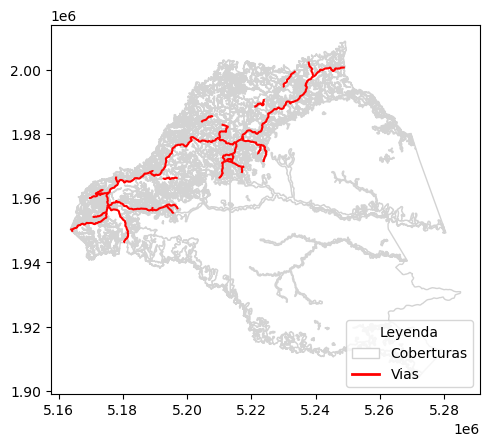

In [131]:
base = coberturas.plot(color='white', edgecolor='lightgrey')
carreteras.plot(ax=base, color='red');

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Coberturas'),
    Line2D([0], [0], color='red', lw=2, label='Vias')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower right')

Visualización - Mapa de intersección entre las carreteras y las áreas de pastos y áreas abiertas. Nuevamente, se dibuja el mapa de coberturas pero ahora destacamos las áreas de pastos y áreas abiertas con un color gris claro, sobreponiendo las carreteras que intersectan con estas áreas en color verde.

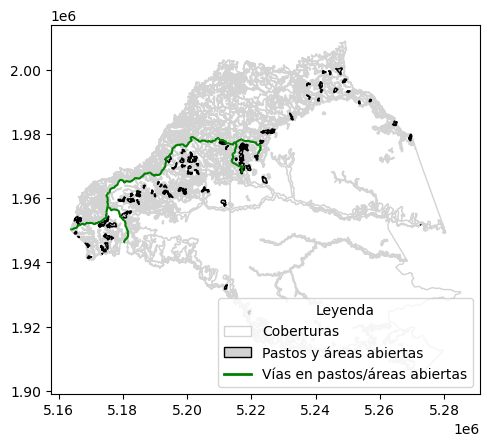

In [132]:
base = coberturas.plot(color='white', edgecolor='lightgrey')
pastos_y_areasabiertas.plot(ax=base, color='lightgrey', edgecolor='black')
vias_p_a.plot(ax=base, color='green');

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Coberturas'),
    Patch(facecolor='lightgrey', edgecolor='black', label='Pastos y áreas abiertas'),
    Line2D([0], [0], color='green', lw=2, label='Vías en pastos/áreas abiertas')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower right')

#### 5.2.2. Areas of influence

##### 1. Create influence zones (buffer) around points or lines, such as rivers or roads.

###### Solución

Se procede a crear un buffer de 1000 m sobre las vías. Para ello, se procede a cargar el archivo shapefile de municipios:

In [133]:
municipios = gpd.read_file("Data\\Municipios.shp")

Establecer el sistema de referencia de coordenadas (CRS) adecuado. Se define el CRS (sistema de referencia espacial) como 9377, que corresponde al sistema UTM para evitar posibles problemas de proyección al crear el buffer de las vías.

In [134]:
crs = 9377

Crear un buffer de 1000 metros alrededor de las vías. Primero, se realiza una copia de la capa de carreteras para no modificar la original. Luego, se convierten las geometrías de las carreteras a la proyección del CRS 9377. Después, se usa el método .buffer(1000) para crear un buffer de 1000 metros alrededor de cada carretera:

In [135]:
vias_buffer = carreteras.copy().to_crs(crs)
vias_buffer.geometry = vias_buffer.buffer(1000)
vias_buffer

TIPO_VIA ESTADO_SUP NUMERO_CAR ACCESIBILI NOMBRE_GEO PROYECTO SYMBOL  \
0          5       3306  Sin Valor       3601       None     None      2   
1          5       3306  Sin Valor       3601       None     None      2   
2          5       3306  Sin Valor       3601       None     None      2   
3          5       3306  Sin Valor       3601       None     None      2   
4          5       3306  Sin Valor       3601       None     None      2   
5          5       3306  Sin Valor       3601       None     None      2   
6          5       3306  Sin Valor       3601       None     None      2   
7          6       3350  Sin Valor       3601       None     None      2   
8          6       3350  Sin Valor       3601       None     None      2   
9          6       3350  Sin Valor       3601       None     None      2   
10         6       3350  Sin Valor       3601       None     None      2   
11         6       3350  Sin Valor       3601       None     None      2   
12         6       3350  Sin Valor       3601       None     None      2   
13         6       3350  Sin Valor       3601       None     None      2   
14         6       3350  Sin Valor       3601       None     None      2   
15         6       3350  Sin Valor       3601       None     None      2   
16         6       3350  Sin Valor       3601       None     None      2   
17         6       3350  Sin Valor       3601       None     None      2   
18         5       3306  Sin Valor       3601       None     None      2   
19         5       3306  Sin Valor       3601       None     None      2   
20         5       3306  Sin Valor       3601       None     None      2   
21         5       3306  Sin Valor       3601       None     None      2   
22         5       3306  Sin Valor       3601       None     None      2   
23         5       3306  Sin Valor       3601       None     None      2   
24         6       3350  Sin Valor       3601       None     None      2   
25         6       3350  Sin Valor       3601       None     None      2   

         FECHA     PK_CUE EJE_VIAL  \
0   0000/00/00  1974511.0     None   
1   0000/00/00  1974512.0     None   
2   0000/00/00  1974513.0     None   
3   0000/00/00  1975213.0     None   
4   0000/00/00  1975214.0     None   
5   0000/00/00  1975216.0     None   
6   0000/00/00  1975218.0     None   
7   0000/00/00  2073749.0     None   
8   0000/00/00  1975495.0     None   
9   0000/00/00  1975496.0     None   
10  0000/00/00  1974719.0     None   
11  0000/00/00  1974721.0     None   
12  0000/00/00  1974722.0     None   
13  0000/00/00  1974826.0     None   
14  0000/00/00  1974827.0     None   
15  0000/00/00  1974828.0     None   
16  0000/00/00  1974829.0     None   
17  0000/00/00  1975118.0     None   
18  0000/00/00  1975384.0     None   
19  0000/00/00  1975393.0     None   
20  0000/00/00  1975394.0     None   
21  0000/00/00  2078226.0     None   
22  0000/00/00  1975395.0     None   
23  0000/00/00  1977024.0     None   
24  0000/00/00  1977030.0     None   
25  0000/00/00  1977031.0     None   

                                             geometry  
0   POLYGON ((5188395.74 1957505.739, 5188403.564 ...  
1   POLYGON ((5174739.42 1957032.492, 5174728.632 ...  
2   POLYGON ((5175161.548 1956208.634, 5175153.19 ...  
3   POLYGON ((5176892.329 1966524.459, 5176894.766...  
4   POLYGON ((5164262.15 1949281.808, 5164175.113 ...  
5   POLYGON ((5209077.417 1966513.065, 5209089.925...  
6   POLYGON ((5163247.601 1949684.003, 5163204.389...  
7   POLYGON ((5170674.347 1953206.25, 5170648.808 ...  
8   POLYGON ((5170684.417 1961036.287, 5170679.04 ...  
9   POLYGON ((5169748.189 1961108.708, 5169802.347...  
10  POLYGON ((5192578.206 1958271.981, 5192634.992...  
11  POLYGON ((5163445.543 1950276.787, 5163505.083...  
12  POLYGON ((5191799.67 1966644.608, 5191828.218 ...  
13  POLYGON ((5187443.57 1968363.568, 5187457.83 1...  
14  POLYGON ((5211322.365 1972400.367, 5211355.72 ...  
15  POLYGON ((5211692.627 19

Visualización del resultado en un mapa. Primero, se dibuja el mapa de municipios con un borde gris claro y fondo blanco. Luego, se sobrepone los buffers de las vías, representados en color azul.

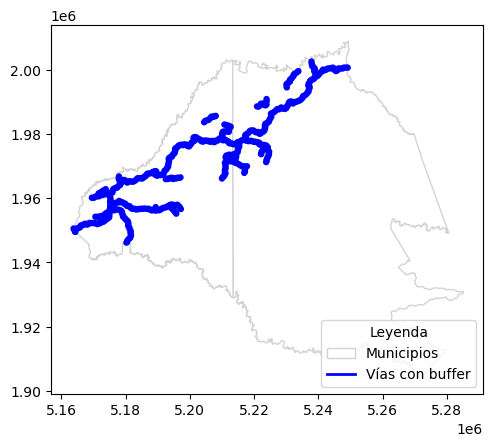

In [136]:
base = municipios.plot(color='white', edgecolor='lightgrey')
vias_buffer.plot(ax=base, color='blue')

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Municipios'),
    Line2D([0], [0], color='blue', lw=2, label='Vías con buffer')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower right')

##### 2. Use the buffer to identify affected areas. e.g. Determine agricultural areas impacted by road buffers.

###### Solución

Se usa el buffer para determinar áreas de bosque de galería que son impactados por los buffer de vías. Para ello, se carga archivo shapefile de coberturas: 

In [137]:
coberturas = gpd.read_file("Data\\Coberturas.shp")

Filtrar los bosques de galería. Se filtran las coberturas para obtener solo aquellas con 'nivel_3' igual a '314', que corresponde a los bosques de galería.

In [138]:
bosques_galeria = coberturas[coberturas['nivel_3'].isin(['314'])]

Identificar las intersecciones entre los bosques de galería y las vías con buffer. Se utiliza el método .intersects() para determinar qué bosques de galería se intersectan con el buffer de las vías. El uso de .union_all() permite combinar todas las geometrías del buffer en una sola para realizar la operación de intersección.

In [139]:
sel = bosques_galeria.intersects(vias_buffer.union_all())

Filtrar solo los bosques de galería que se intersectan con las vías (y su buffer). Se seleccionan solo las áreas de bosques de galería que se intersectan con las vías y sus buffers.

In [140]:
bosques_galeria_intersect = bosques_galeria[sel]
bosques_galeria_intersect

OBJECTID  codigo                             leyenda  \
167   272382.0     314  3.1.4. Bosque de galería y ripario   
168   272383.0     314  3.1.4. Bosque de galería y ripario   
194   272407.0     314  3.1.4. Bosque de galería y ripario   
216   272434.0     314  3.1.4. Bosque de galería y ripario   
217   272435.0     314  3.1.4. Bosque de galería y ripario   
...        ...     ...                                 ...   
1349  285382.0     314  3.1.4. Bosque de galería y ripario   
1350  285382.0     314  3.1.4. Bosque de galería y ripario   
1386  285414.0     314  3.1.4. Bosque de galería y ripario   
1387  285414.0     314  3.1.4. Bosque de galería y ripario   
1388  285414.0     314  3.1.4. Bosque de galería y ripario   

                             insumo        apoyo confiabili  cambio nivel_1  \
167               L8_657_20200205p1         None         SI       1       3   
168               L8_657_20200205p1         None         SI       1       3   
194               L8_657_20200205p1         None         SI       1       3   
216   Landsat_2020_Mediana_07042021  GoogleEarth         SI       1       3   
217   Landsat_2020_Mediana_07042021  GoogleEarth         SI       1       3   
...                             ...          ...        ...     ...     ...   
1349              L8_657_20200205p1         None         SI       1       3   
1350              L8_657_20200205p1         None         SI       1       3   
1386  Landsat_2020_Mediana_07042021  GoogleEarth         SI       1       3   
1387  Landsat_2020_Mediana_07042021  GoogleEarth         SI       1       3   
1388  Landsat_2020_Mediana_07042021  GoogleEarth         SI       1       3   

     nivel_2 nivel_3 nivel_4 nivel_5 nivel_6     area_ha  ORIG_FID  \
167       31     314    None    None    None  376.599291        67   
168       31     314    None    None    None   48.600122        68   
194       31     314    None    None    None    6.555301        92   
216       31     314    None    None    None  685.772267       108   
217       31     314    None    None    None   42.776478       109   
...      ...     ...     ...     ...     ...         ...       ...   
1349      31     314    None    None    None   14.654497       778   
1350      31     314    None    None    None   14.654497       778   
1386      31     314    None    None    None  990.778096       802   
1387      31     314    None    None    None  990.778096       802   
1388      31     314    None    None    None  990.778096       802   

         Shape_Leng    Shape_Area  \
167    43178.989103  3.765993e+06   
168     7061.133610  4.860012e+05   
194     1756.122872  6.555301e+04   
216   139687.772900  6.857723e+06   
217     9130.679716  4.277648e+05   
...             ...           ...   
1349     128.146315  5.750542e+02   
1350    3044.995296  1.459699e+05   
1386  113365.394522  8.327907e+06   
1387    2055.112096  6.488600e+04   
1388   33677.141238  1.359139e+06   

                                               geometry  
167   POLYGON Z ((5203971.601 1967880.747 0, 5203932...  
168   POLYGON Z ((5210033.243 1970097.469 0, 5210033...  
194   POLYGON Z ((5213402.329 1972865.168 0, 5213398...  
216   POLYGON Z ((5194279.983 1981765.853 0, 5194296...  
217   POLYGON Z ((5198574.913 1977412.314 0, 5198568...  
...                                                 ...  
1349  POLYGON Z ((5213402.89 1972635.576 0, 5213402....  
1350  POLYGON Z ((5214007.765 1971713.795 0, 5214008...  
1386  POLYGON Z ((5215015.659 1988090.159 0, 5215038...  
1387  POLYGON Z ((5213381.022 1981587.834 0, 5213380...  
1388  POLYGON Z ((5213392.059 1977069.504 0, 5213391...  

[61 rows x 18 columns]

Visualización en un mapa. Primero, se dibuja el mapa de municipios con borde gris claro y fondo blanco. Luego, se muestra los bosques de galería en color gris claro con borde oscuro. A continuación, se visualizan los bosques de galería que se intersectan con las vías en color gris claro y borde púrpura. Finalmente, se dibujan los buffers de las vías en color azul.

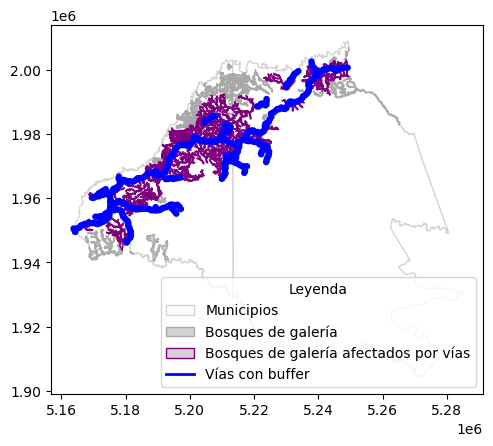

In [141]:
base = municipios.plot(color='white', edgecolor='lightgrey')
bosques_galeria.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
bosques_galeria_intersect.plot(ax=base, color='lightgrey', edgecolor='purple')
vias_buffer.plot(ax=base, color='blue')

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Municipios'),
    Patch(facecolor='lightgrey', edgecolor='darkgrey', label='Bosques de galería'),
    Patch(facecolor='lightgrey', edgecolor='purple', label='Bosques de galería afectados por vías'),
    Line2D([0], [0], color='blue', lw=2, label='Vías con buffer')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower right')

#### 5.2.3. Overlay operations

##### 1. Combine two vector layers (e.g., conservation areas and hazard zones) to generate a new layer with the intersection. 

###### Solución

Se combina la capa de coberturas específicas y de municipios para generar la insertersección. Para ello, se cargan archivos shapefile de coberturas y municipios:

In [142]:
coberturas = gpd.read_file("Data\\Coberturas.shp")
municipios = gpd.read_file("Data\\Municipios.shp")

Filtrar coberturas específicas de interés. Se filtran las coberturas para obtener solo aquellas con 'nivel_3' igual a '411', '511', o '334'. 

In [143]:
coberturas_interes = coberturas[coberturas['nivel_3'].isin(['411','511','334'])]

Identificar municipios que se intersectan con las coberturas de interés. Se utiliza el método .intersects() para determinar qué municipios se intersectan con las coberturas específicas. El uso de .union_all() permite combinar todas las geometrías de las coberturas en una sola para realizar la operación de intersección.

In [144]:
municipios_x_coberturas = municipios[municipios.intersects(coberturas_interes.union_all())]
municipios_x_coberturas

FID_Limite MpCodigo       MpNombre        MpArea                   MpNorma  \
0        1328    50325      Mapiripan  11917.401464  Ordenanza No. 11 de 1989   
1        1500    50568  Puerto Gaitan  17199.254178  Ordenanza No. 39 de 1969   
2        1669    99773       Cumaribo  65187.505271  Ordenanza No. 66 de 1996   

   MpCategor  MpAltitud                                         Restriccio  \
0          1        200  “No es apropiada su aplicación para la ubicaci...   
1          1        149  “No es apropiada su aplicación para la ubicaci...   
2          1        161  “No es apropiada su aplicación para la ubicaci...   

     Depto     AREA_TOTAL                                           geometry  
0     Meta      33.861013  MULTIPOLYGON Z (((5176114.636 1943033.105 0, 5...  
1     Meta  186676.364946  POLYGON Z ((5213329.219 2002795.708 0, 5213509...  
2  Vichada  486596.210986  POLYGON Z ((5213509.28 1929080.432 0, 5213329....

Realizar una unión espacial entre las coberturas de interés y los municipios. Se utiliza el método .sjoin() para realizar una unión espacial entre las dos capas, de modo que cada municipio tendrá la información de las coberturas de interés con las que se cruza

In [145]:
mxc_join = coberturas_interes.sjoin(municipios, how='left')
mxc_join

OBJECTID  codigo      leyenda  \
50    256925.0     511  5.1.1. Ríos   
50    256925.0     511  5.1.1. Ríos   
51    256925.0     511  5.1.1. Ríos   
51    256925.0     511  5.1.1. Ríos   
52    256925.0     511  5.1.1. Ríos   
...        ...     ...          ...   
1664  311003.0     511  5.1.1. Ríos   
1665  311003.0     511  5.1.1. Ríos   
1666  311003.0     511  5.1.1. Ríos   
1667  311003.0     511  5.1.1. Ríos   
1668  311003.0     511  5.1.1. Ríos   

                                                 insumo                 apoyo  \
50    L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
50    L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
51    L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
51    L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
52    L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
...                                                 ...                   ...   
1664  L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
1665  L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
1666  L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
1667  L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   
1668  L8_457_20200106, L8_557_20200113, Landsat_2020...  Basemap, GoogleEarth   

     confiabili  cambio nivel_1 nivel_2 nivel_3  ... FID_Limite MpCodigo  \
50           SI       2       5      51     511  ...       1328    50325   
50           SI       2       5      51     511  ...       1500    50568   
51           SI       2       5      51     511  ...       1328    50325   
51           SI       2       5      51     511  ...       1500    50568   
52           SI       2       5      51     511  ...       1328    50325   
...         ...     ...     ...     ...     ...  ...        ...      ...   
1664         SI       2       5      51     511  ...       1669    99773   
1665         SI       2       5      51     511  ...       1669    99773   
1666         SI       2       5      51     511  ...       1669    99773   
1667         SI       2       5      51     511  ...       1669    99773   
1668         SI       2       5      51     511  ...       1669    99773   

           MpNombre        MpArea                   MpNorma  MpCategor  \
50        Mapiripan  11917.401464  Ordenanza No. 11 de 1989          1   
50    Puerto Gaitan  17199.254178  Ordenanza No. 39 de 1969          1   
51        Mapiripan  11917.401464  Ordenanza No. 11 de 1989          1   
51    Puerto Gaitan  17199.254178  Ordenanza No. 39 de 1969          1   
52        Mapiripan  11917.401464  Ordenanza No. 11 de 1989          1   
...             ...           ...                       ...        ...   
1664       Cumaribo  65187.505271  Ordenanza No. 66 de 1996          1   
1665       Cumaribo  65187.505271  Ordenanza No. 66 de 1996          1   
1666       Cumaribo  65187.505271  Ordenanza No. 66 de 1996          1   
1667       Cumaribo  65187.505271  Ordenanza No. 66 de 1996          1   
1668       Cumaribo  65187.505271  Ordenanza No. 66 de 1996          1   

      MpAltitud                                         Restriccio    Depto  \
50          200  “No es apropiada su aplicación para la ubicaci...     Meta   
50          149  “No es apropiada su aplicación para la ubicaci...     Meta   
51          200  “No es apropiada su aplicación para la ubicaci...     Meta   
51          149  “No es apropiada su aplicación para la ubicaci...     Meta   
52          200  “No es apropiada su aplicación para la ubicaci...     Meta   
...         ...                                                ...      ...   
1664        161  “No es apropiada su aplicación para la ubicaci...  Vichada   
1665        161  “No es apropiada su aplicación para la ubicaci...  Vichada   
1666        161  “No es apropiada su aplicación par

Visualización de los resultados. Primero, se dibuja el mapa de municipios con borde gris claro y fondo blanco. Luego, se muestran las coberturas de interés con bordes rojos (sin color de relleno) sobre el mapa.

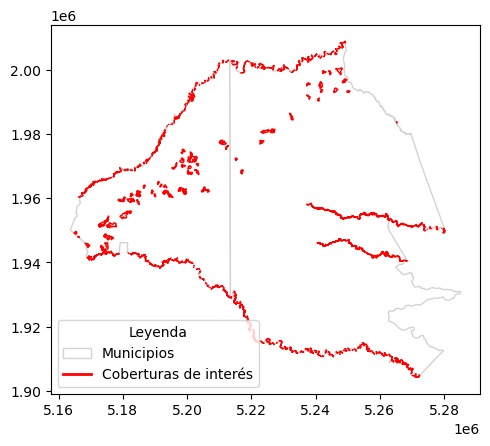

In [146]:
base = municipios.plot(color='white', edgecolor='lightgrey')
coberturas_interes.plot(ax=base, color='None', edgecolor='red')

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Municipios'),
    Line2D([0], [0], color='red', lw=2, label='Coberturas de interés')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower left')

Visualizar los municipios que se intersectan con las coberturas de interés. Aquí, se muestran los municipios que se intersectan con las coberturas de interés, coloreados por el nombre del municipio

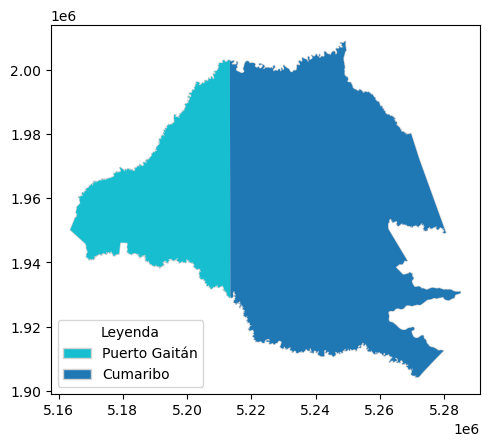

In [147]:
base = municipios.plot(color='white', edgecolor='lightgrey')
municipios_x_coberturas.plot(ax=base, column='MpNombre');

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='#17becf', edgecolor='lightgrey', label='Puerto Gaitán'),
    Patch(facecolor='#1f77b4', edgecolor='lightgrey', label='Cumaribo')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower left')

Visualización de la unión espacial (join). Se dibujan los municipios y se muestran las geometrías de la unión espacial (join) en gris. Posteriormente, se visualizan las coberturas de interés en color gris y las uniones espaciales con el color de 'nivel_3', con una leyenda para indicar qué significa cada color.

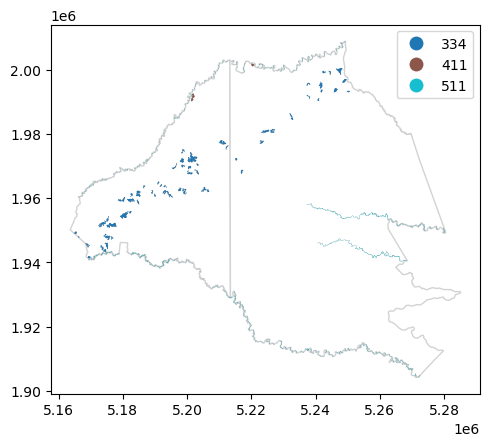

In [148]:
base = municipios.plot(color='white', edgecolor='lightgrey')
mxc_join.geometry.plot(ax=base, color='grey')
mxc_join.plot(ax=base, column='nivel_3', legend=True);

##### 2. Identify parts of a layer not overlapping with another. e.g.Conservation zones outside urban areas.

###### Solución

Se identifican humedales en coberturas transformadas, como indicio de humedales transformados o afectados. Para ello, se cargan archivos shapefile de coberturas y humedales:

In [149]:
coberturas = gpd.read_file("Data\\Coberturas.shp")
humedales = gpd.read_file("Data\\Humedales.shp")

Filtrar coberturas que pertenecen al nivel '2' (por ejemplo, zonas de conservación). Se filtran las coberturas para obtener solo aquellas que están en el nivel 1 igual a '2': 

In [150]:
coberturas_transformadas = coberturas[coberturas['nivel_1'].isin(['2'])]

Identificar humedales que se intersectan con las coberturas transformadas. Se encuentra la intersección de los humedales con las coberturas que han sido seleccionadas. Esto ayuda a identificar los humedales dentro de zonas de conservación

In [151]:
humedales_x_coberturas = humedales[humedales.intersects(coberturas_transformadas.union_all())]
humedales_x_coberturas

FID_Humeda  Nivel_Hume     Area_Ha Fecha_Ingr  Fecha_Reco    NOMAH  \
27        233529           2  556.012019 2020-08-28  0000/00/00  Orinoco   
35        233537           2    5.423633 2020-08-28  0000/00/00  Orinoco   
54        233560           2    0.976523 2020-08-28  0000/00/00  Orinoco   
63        233942           2  173.503146 2020-08-28  0000/00/00  Orinoco   
71        234525           1   93.043699 2020-08-28  0000/00/00  Orinoco   
...          ...         ...         ...        ...         ...      ...   
3686      265309           1   99.968461 2020-08-28  0000/00/00  Orinoco   
3687      265312           1  114.639137 2020-08-28  0000/00/00  Orinoco   
3694      265330           1    1.636066 2020-08-28  0000/00/00  Orinoco   
3701      265341           1   17.733602 2020-08-28  0000/00/00  Orinoco   
3753      265463           1    0.446660 2020-08-28  0000/00/00  Orinoco   

         NOMZH        NOMSZH    Grado_Tran  FID_RI_UNU  ...  MUNICIPIO  \
27     Vichada  Alto Vichada       Natural           0  ...      99773   
35     Vichada  Alto Vichada       Natural           0  ...      99773   
54     Vichada  Alto Vichada  Transformado           0  ...      99773   
63     Vichada  Alto Vichada       Natural           0  ...      99773   
71     Vichada  Alto Vichada             -           0  ...      99773   
...        ...           ...           ...         ...  ...        ...   
3686  Guaviare  Río Iteviare             -           0  ...      99773   
3687  Guaviare  Río Iteviare             -           0  ...      99773   
3694  Guaviare  Río Iteviare             -           0  ...      99773   
3701  Guaviare  Río Iteviare             -           0  ...      99773   
3753  Guaviare  Río Iteviare             -           0  ...      99773   

     CODIGO_DAN                                GlobalID    Shape__Are  \
27         1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
35         1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
54         1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
63         1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
71         1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
...         ...                                     ...           ...   
3686       1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
3687       1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
3694       1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
3701       1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   
3753       1338  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09   

         Shape__Len     Shape_Leng  Shape_Le_1    Shape_Le_2    Shape_Area  \
27    714187.420836  714187.420836    0.242395  26876.776205  5.262702e+06   
35    714187.420836  714187.420836    0.036321   4024.668579  5.418951e+04   
54    714187.420836  714187.420836    0.029295   3252.165935  9.756412e+03   
63    714187.420836  714187.420836    0.139551  15455.894200  1.733758e+06   
71    714187.420836  714187.420836    0.262868  29124.833939  9.012037e+05   
...             ...            ...         ...           ...           ...   
3686  714187.420836  714187.420836    0.143474  15899.128365  9.992048e+05   
3687  714187.420836  714187.420836    0.162484  18006.222576  1.145453e+06   
3694  714187.420836  714187.420836    0.000312     34.475279  1.005300e+01   
3701  714187.420836  714187.420836    0.060815   6736.234167  1.772507e+05   
3753  714187.420836  714187.420836    0.014877   1646.821799  4.331500e+03   

                                               geometry  
27    POLYGON Z ((5165879.926 1956823.107 0, 5165879...  
35    MULTIPOLYGON Z (((5172353.694 1954930.184 0, 5...  
54    MULTIPOLYGON Z (((5169031.652 1954137.145 0, 5...  
63    POLYGON Z ((5187421.462 1970317.117 0, 5187387...  
71    MULTIPOLYGON Z (((5184936.36 1969913.424 0, 51...  
...                                       

Realizar una unión espacial entre las coberturas transformadas y los humedales. El método .sjoin() se utiliza para realizar una unión espacial entre las capas de humedales y las coberturas transformadas. De esta manera, se asignan las propiedades de las coberturas a los humedales que se intersectan con ellas:

In [152]:
hxc_join = coberturas_transformadas.sjoin(humedales, how='left')
hxc_join

OBJECTID_left  codigo                                          leyenda  \
6          252930.0     244  2.4.4. Mosaico de pastos con espacios naturales   
6          252930.0     244  2.4.4. Mosaico de pastos con espacios naturales   
6          252930.0     244  2.4.4. Mosaico de pastos con espacios naturales   
6          252930.0     244  2.4.4. Mosaico de pastos con espacios naturales   
18         253003.0     231                            2.3.1. Pastos limpios   
...             ...     ...                                              ...   
1396       285521.0     244  2.4.4. Mosaico de pastos con espacios naturales   
1396       285521.0     244  2.4.4. Mosaico de pastos con espacios naturales   
1411       285644.0     244  2.4.4. Mosaico de pastos con espacios naturales   
1411       285644.0     244  2.4.4. Mosaico de pastos con espacios naturales   
1415       285648.0     244  2.4.4. Mosaico de pastos con espacios naturales   

                             insumo        apoyo confiabili  cambio nivel_1  \
6                 L8_658_20200205p1         None         SI       2       2   
6                 L8_658_20200205p1         None         SI       2       2   
6                 L8_658_20200205p1         None         SI       2       2   
6                 L8_658_20200205p1         None         SI       2       2   
18                L8_658_20200205p1         None         SI       2       2   
...                             ...          ...        ...     ...     ...   
1396  Landsat_2020_Mediana_07042021  GoogleEarth         SI       1       2   
1396  Landsat_2020_Mediana_07042021  GoogleEarth         SI       1       2   
1411              L8_657_20200205p1         None         SI       2       2   
1411              L8_657_20200205p1         None         SI       2       2   
1415              L8_657_20200205p1         None         SI       1       2   

     nivel_2 nivel_3  ... DEPARTAMEN MUNICIPIO CODIGO_DAN  \
6         24     244  ...         99     99773       1338   
6         24     244  ...         99     99773       1338   
6         24     244  ...         99     99773       1338   
6         24     244  ...         99     99773       1338   
18        23     231  ...         99     99773       1338   
...      ...     ...  ...        ...       ...        ...   
1396      24     244  ...         99     99773       1338   
1396      24     244  ...         99     99773       1338   
1411      24     244  ...         99     99773       1338   
1411      24     244  ...         99     99773       1338   
1415      24     244  ...        NaN       NaN        NaN   

                                    GlobalID    Shape__Are     Shape__Len  \
6     {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
6     {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
6     {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
6     {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
18    {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
...                                      ...           ...            ...   
1396  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
1396  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
1411  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
1411  {B6B40B25-9950-436B-963E-0BDCA375F1CF}  6.733064e+09  714187.420836   
1415                                     NaN           NaN            NaN   

      Shape_Leng_right Shape_Le_1     Shape_Le_2  Shape_Area_right  
6        714187.420836   1.388824  153941.067770      2.553928e+06  
6        714187.420836   0.013996    1549.183350      2.374348e+03  
6        714187.420836   0.002572     284.605323      1.113019e+03  
6        714187.420836   0.003438     380.652100      8.613971e+02  
18       714187.420836   1.388824  153941.067770      2.553928e+06  
...                ...  

Visualización de los resultados. Primero, se dibuja el mapa de humedales con borde gris claro y fondo blanco. Luego, se muestra las coberturas transformadas con bordes rojos (sin color de relleno) sobre el mapa.

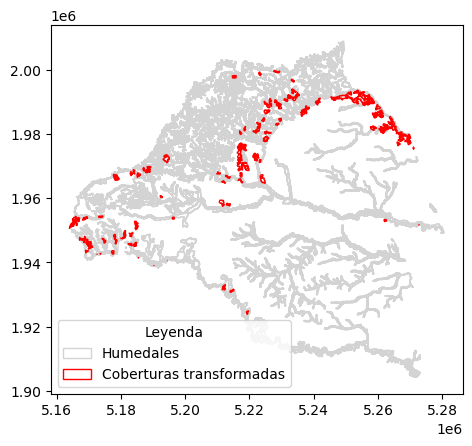

In [153]:
base = humedales.plot(color='white', edgecolor='lightgrey')
coberturas_transformadas.plot(ax=base, color='None', edgecolor='red');

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Humedales'),
    Patch(facecolor='white', edgecolor='red', label='Coberturas transformadas')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower left')

Visualizar los humedales que se intersectan con las coberturas transformadas. Aquí, se muestran los humedales que se intersectan con las coberturas seleccionadas, coloreados por la columna 'Nivel_Hume'

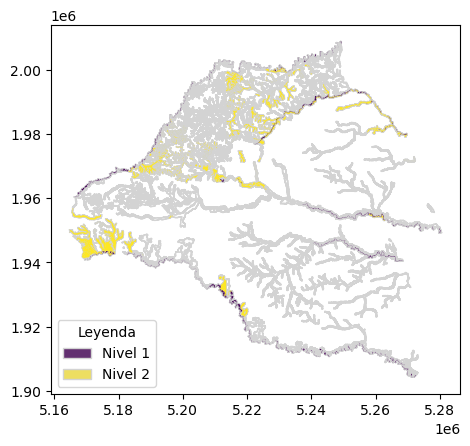

In [154]:
base = humedales.plot(color='white', edgecolor='lightgrey')
humedales_x_coberturas.plot(ax=base, column='Nivel_Hume');

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='#622f70', edgecolor='lightgrey', label='Nivel 1'),
    Patch(facecolor='#edde61', edgecolor='lightgrey', label='Nivel 2')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower left')

Visualización de la unión espacial (join). Se dibuja los humedales y mostramos las geometrías de la unión espacial (join) en gris. Posteriormente, se visualizan las coberturas transformadas en color gris y las uniones espaciales con el color de 'nivel_3', con una leyenda para indicar qué significa cada color:

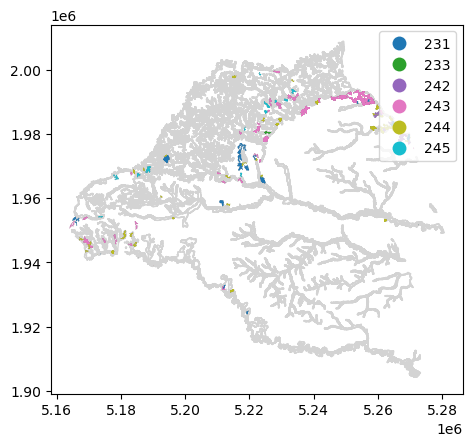

In [155]:
base = humedales.plot(color='white', edgecolor='lightgrey')
hxc_join.geometry.plot(ax=base, color='grey')
hxc_join.plot(ax=base, column='nivel_3', legend=True);

#### 5.2.4. Joins

##### 1. Perform a spatial join. e.g. Enrich a layer of crop points with attributes from administrative regions.

###### Solución

Enriquecer puntos de parcelas de bosque con los datos de los municipios. Se importa la librería necesaria y se carga la capa de municipios desde el archivo shapefile:

In [156]:
import numpy as np

municipios = gpd.read_file("Data\\Municipios.shp")

Fijar una semilla para hacer los resultados reproducibles. Obtener los límites totales de la capa de municipios. Se generan 10 puntos aleatorios dentro de los límites del municipio 'x' y 'y' son las coordenadas de los puntos generados aleatoriamente dentro del bounding box de los municipios.

In [157]:
np.random.seed(1)       ## set seed for reproducibility
bb = municipios.total_bounds  ## the world's bounds
x = np.random.uniform(low=bb[0], high=bb[2], size=10)
y = np.random.uniform(low=bb[1], high=bb[3], size=10)

Crear una GeoDataFrame con los puntos aleatorios generados. Se usa la función 'points_from_xy' de geopandas para convertir las coordenadas (x, y) a geometrías de puntos.

In [158]:
random_points = gpd.points_from_xy(x, y, crs=9377)
plot_forest = gpd.GeoDataFrame({'geometry': random_points})
plot_forest

geometry
0  POINT (5214310.678 1948075.339)
1  POINT (5251170.025 1975903.617)
2  POINT (5163645.275 1925611.632)
3  POINT (5200372.851 1996082.238)
4  POINT (5181466.132 1907089.295)
5  POINT (5174852.979 1974360.444)
6  POINT (5186266.962 1947877.661)
7  POINT (5205626.226 1962667.631)
8  POINT (5211849.212 1918909.903)
9  POINT (5229111.988 1924947.293)

Convertir la capa de municipios al CRS de los puntos aleatorios. Se asegura que ambas capas tengan el mismo CRS para poder realizar la operación espacial correctamente

In [159]:
municipios = municipios.to_crs(plot_forest.crs)

Seleccionar los municipios que intersectan con los puntos generados aleatoriamente. Esto permite identificar en qué municipios caen los puntos aleatorios:

In [160]:
municipios_random = municipios[municipios.intersects(plot_forest.union_all())]
municipios_random

FID_Limite MpCodigo       MpNombre        MpArea                   MpNorma  \
1        1500    50568  Puerto Gaitan  17199.254178  Ordenanza No. 39 de 1969   
2        1669    99773       Cumaribo  65187.505271  Ordenanza No. 66 de 1996   

   MpCategor  MpAltitud                                         Restriccio  \
1          1        149  “No es apropiada su aplicación para la ubicaci...   
2          1        161  “No es apropiada su aplicación para la ubicaci...   

     Depto     AREA_TOTAL                                           geometry  
1     Meta  186676.364946  POLYGON Z ((5213329.219 2002795.708 0, 5213509...  
2  Vichada  486596.210986  POLYGON Z ((5213509.28 1929080.432 0, 5213329....

Realizar una unión espacial (spatial join) entre los puntos aleatorios y los municipios. El método 'sjoin' permite unir las columnas de los municipios con los puntos aleatorios que caen dentro de sus límites.

In [161]:
random_joined = plot_forest.sjoin(municipios, how='left')
random_joined

geometry  index_right  FID_Limite MpCodigo  \
0  POINT (5214310.678 1948075.339)          2.0      1669.0    99773   
1  POINT (5251170.025 1975903.617)          2.0      1669.0    99773   
2  POINT (5163645.275 1925611.632)          NaN         NaN      NaN   
3  POINT (5200372.851 1996082.238)          NaN         NaN      NaN   
4  POINT (5181466.132 1907089.295)          NaN         NaN      NaN   
5  POINT (5174852.979 1974360.444)          NaN         NaN      NaN   
6  POINT (5186266.962 1947877.661)          1.0      1500.0    50568   
7  POINT (5205626.226 1962667.631)          1.0      1500.0    50568   
8  POINT (5211849.212 1918909.903)          NaN         NaN      NaN   
9  POINT (5229111.988 1924947.293)          2.0      1669.0    99773   

        MpNombre        MpArea                   MpNorma  MpCategor  \
0       Cumaribo  65187.505271  Ordenanza No. 66 de 1996        1.0   
1       Cumaribo  65187.505271  Ordenanza No. 66 de 1996        1.0   
2            NaN           NaN                       NaN        NaN   
3            NaN           NaN                       NaN        NaN   
4            NaN           NaN                       NaN        NaN   
5            NaN           NaN                       NaN        NaN   
6  Puerto Gaitan  17199.254178  Ordenanza No. 39 de 1969        1.0   
7  Puerto Gaitan  17199.254178  Ordenanza No. 39 de 1969        1.0   
8            NaN           NaN                       NaN        NaN   
9       Cumaribo  65187.505271  Ordenanza No. 66 de 1996        1.0   

   MpAltitud                                         Restriccio    Depto  \
0      161.0  “No es apropiada su aplicación para la ubicaci...  Vichada   
1      161.0  “No es apropiada su aplicación para la ubicaci...  Vichada   
2        NaN                                                NaN      NaN   
3        NaN                                                NaN      NaN   
4        NaN                                                NaN      NaN   
5        NaN                                                NaN      NaN   
6      149.0  “No es apropiada su aplicación para la ubicaci...     Meta   
7      149.0  “No es apropiada su aplicación para la ubicaci...     Meta   
8        NaN                                                NaN      NaN   
9      161.0  “No es apropiada su aplicación para la ubicaci...  Vichada   

      AREA_TOTAL  
0  486596.210986  
1  486596.210986  
2            NaN  
3            NaN  
4            NaN  
5            NaN  
6  186676.364946  
7  186676.364946  
8            NaN  
9  486596.210986

Visualización de los resultados. Dibujar el mapa de municipios con borde gris claro y fondo blanco. Luego, mostrar los puntos generados aleatoriamente (en rojo) sobre el mapa

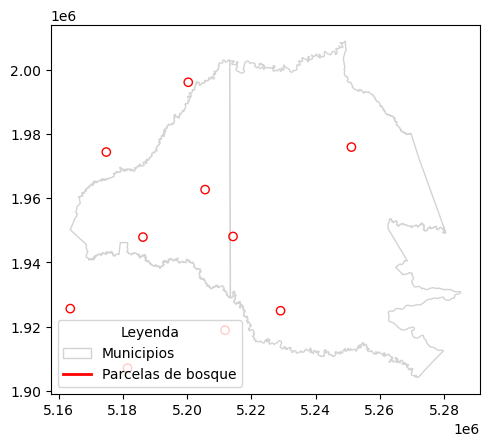

In [162]:
base = municipios.plot(color='white', edgecolor='lightgrey')
plot_forest.plot(ax=base, color='None', edgecolor='red');

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='white', edgecolor='lightgrey', label='Municipios'),
    Line2D([0], [0], color='red', lw=2, label='Parcelas de bosque')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='lower left')

Visualizar los municipios que contienen los puntos generados. Mostrar los municipios que se intersectan con los puntos aleatorios, coloreados por el nombre del municipio ('MpNombre').

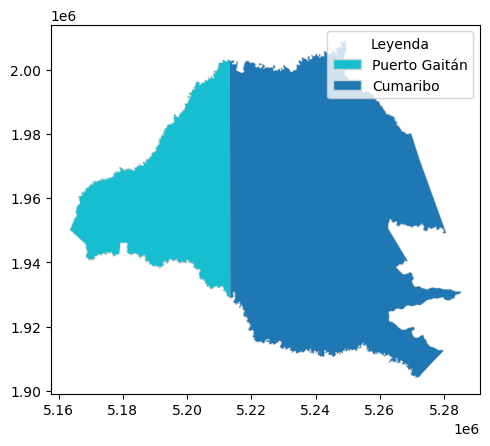

In [163]:
base = municipios.plot(color='white', edgecolor='lightgrey')
municipios_random.plot(ax=base, column='MpNombre');

# Crear los handles para la leyenda
handles = [
    Patch(facecolor='#17becf', edgecolor='lightgrey', label='Puerto Gaitán'),
    Patch(facecolor='#1f77b4', edgecolor='lightgrey', label='Cumaribo')
]

# Agregar la leyenda
plt.legend(handles=handles, title="Leyenda", loc='upper right')

Visualización de los puntos con la información de los municipios unida. Mostrar los puntos aleatorios en gris, y luego agregar la información unida de los municipios.

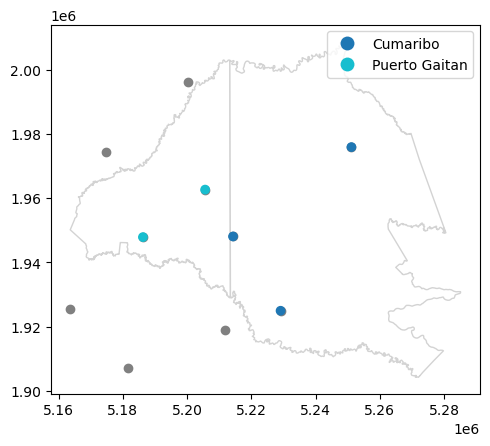

In [164]:
base = municipios.plot(color='white', edgecolor='lightgrey')
random_joined.geometry.plot(ax=base, color='grey')
random_joined.plot(ax=base, column='MpNombre', legend=True);

#### 5.2.5. Joining Incongruent Layers

##### 1. Create a synthetic grid layer of rectangular polygons over the extent of their project data.

###### Solución

Este código tiene como objetivo crear una capa de cuadrícula sintética de polígonos rectangulares sobre la extensión de los datos de un proyecto. La cuadrícula se genera automáticamente a partir de los límites de un área de estudio (en este caso, los municipios), y cada celda de la cuadrícula tiene un tamaño definido (10 km x 10 km). Importar la librería shapely para trabajar con geometrías. Se carga la capa de municipios desde un archivo shapefile.

In [165]:
import shapely

municipios = gpd.read_file("Data\\Municipios.shp")

Configuración de la cuadrícula: extensión, resolución y CRS. 

In [166]:
#Obtener los límites (bounding box) de la capa de municipios
bounds = municipios.total_bounds
# Obtener el sistema de referencia de coordenadas (CRS) de la capa de municipios
crs = municipios.crs
# Definir la resolución de la cuadrícula (tamaño de las celdas en metros)
res = 10000  # 10 km por celda

Calcular las dimensiones de la cuadrícula a partir de los límites

In [167]:
xmin, ymin, xmax, ymax = bounds

Crear listas de las posiciones en las que estarán las columnas y filas de la cuadrícula

In [168]:
# Las columnas se calculan en función de los límites 'xmin' y 'xmax', con una separación de 'res'
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax+res)), res))
# Las filas se calculan en función de los límites 'ymin' y 'ymax', con una separación de 'res'
# Se invierten para crear filas en orden de abajo hacia arriba (como en un sistema de coordenadas cartesiano)
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax+res)), res))
rows.reverse()

Para cada celda en la cuadrícula, crear un polígono rectangular con 'shapely'.

In [224]:
# Utilizamos 'shapely.Polygon' para crear un rectángulo definido por las coordenadas de las esquinas
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([(x,y), (x+res, y), (x+res, y-res), (x, y-res)])
        )

Crear un GeoDataFrame con los polígonos generados

In [225]:
# Cada polígono representa una celda de la cuadrícula
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

Eliminar las filas y columnas de la cuadrícula que están fuera de los límites de la capa de municipios

In [226]:
# Usamos 'intersects' para asegurarnos de que los polígonos de la cuadrícula estén dentro de la extensión de los municipios
sel = grid.intersects(shapely.box(*bounds))  # 'shapely.box(*bounds)' crea un polígono del bounding box
grid = grid[sel]  # Seleccionar solo los polígonos que intersectan con los límites del municipio

Add unique IDs to each grid cell.

In [172]:
grid['id'] = grid.index
grid

geometry   id
0    POLYGON ((5163631 2014224, 5173631 2014224, 51...    0
1    POLYGON ((5163631 2004224, 5173631 2004224, 51...    1
2    POLYGON ((5163631 1994224, 5173631 1994224, 51...    2
3    POLYGON ((5163631 1984224, 5173631 1984224, 51...    3
4    POLYGON ((5163631 1974224, 5173631 1974224, 51...    4
..                                                 ...  ...
150  POLYGON ((5283631 1954224, 5293631 1954224, 52...  150
151  POLYGON ((5283631 1944224, 5293631 1944224, 52...  151
152  POLYGON ((5283631 1934224, 5293631 1934224, 52...  152
153  POLYGON ((5283631 1924224, 5293631 1924224, 52...  153
154  POLYGON ((5283631 1914224, 5293631 1914224, 52...  154

[143 rows x 2 columns]

##### 2. Calculate the area-weighted proportion for each attribute in the project layer and assign it to the grid.

###### Solución 

Este código tiene como objetivo realizar un análisis espacial para calcular el área de bosque por municipio, asignando áreas específicas de bosque a celdas de una cuadrícula. Se cargan las capas de coberturas y municipios desde archivos shapefile

In [173]:
coberturas = gpd.read_file("Data\\Coberturas.shp")
municipios = gpd.read_file("Data\\Municipios.shp")

Filtrar las coberturas para obtener solo aquellas relacionadas con bosques.

In [174]:
# Se seleccionan las coberturas de los niveles 311, 314 y 313 (tipos de bosques)
bosque = coberturas[coberturas['nivel_3'].isin(['311','314','313'])]

Seleccionar los municipios que intersectan con las coberturas de bosque.

In [175]:
municipios_x_bosque = municipios[municipios.intersects(bosque.union_all())]
municipios_x_bosque

FID_Limite MpCodigo       MpNombre        MpArea                   MpNorma  \
0        1328    50325      Mapiripan  11917.401464  Ordenanza No. 11 de 1989   
1        1500    50568  Puerto Gaitan  17199.254178  Ordenanza No. 39 de 1969   
2        1669    99773       Cumaribo  65187.505271  Ordenanza No. 66 de 1996   

   MpCategor  MpAltitud                                         Restriccio  \
0          1        200  “No es apropiada su aplicación para la ubicaci...   
1          1        149  “No es apropiada su aplicación para la ubicaci...   
2          1        161  “No es apropiada su aplicación para la ubicaci...   

     Depto     AREA_TOTAL                                           geometry  
0     Meta      33.861013  MULTIPOLYGON Z (((5176114.636 1943033.105 0, 5...  
1     Meta  186676.364946  POLYGON Z ((5213329.219 2002795.708 0, 5213509...  
2  Vichada  486596.210986  POLYGON Z ((5213509.28 1929080.432 0, 5213329....

Realizar una unión espacial entre los municipios y las coberturas de bosque.

In [176]:
mxc_join = bosque.sjoin(municipios, how='left')
mxc_join

OBJECTID  codigo                                       leyenda  \
0     252916.0     314            3.1.4. Bosque de galería y ripario   
0     252916.0     314            3.1.4. Bosque de galería y ripario   
1     252916.0     314            3.1.4. Bosque de galería y ripario   
1     252916.0     314            3.1.4. Bosque de galería y ripario   
2     252916.0     314            3.1.4. Bosque de galería y ripario   
...        ...     ...                                           ...   
1424  287434.0   31111  3.1.1.1.1. Bosque denso alto de tierra firme   
1425  287434.0   31111  3.1.1.1.1. Bosque denso alto de tierra firme   
1426  287434.0   31111  3.1.1.1.1. Bosque denso alto de tierra firme   
1427  287434.0   31111  3.1.1.1.1. Bosque denso alto de tierra firme   
1428  287434.0   31111  3.1.1.1.1. Bosque denso alto de tierra firme   

                 insumo apoyo confiabili  cambio nivel_1 nivel_2 nivel_3  ...  \
0     L8_658_20200205p1  None         SI       1       3      31     314  ...   
0     L8_658_20200205p1  None         SI       1       3      31     314  ...   
1     L8_658_20200205p1  None         SI       1       3      31     314  ...   
1     L8_658_20200205p1  None         SI       1       3      31     314  ...   
2     L8_658_20200205p1  None         SI       1       3      31     314  ...   
...                 ...   ...        ...     ...     ...     ...     ...  ...   
1424  L8_658_20200205p1  None         SI       2       3      31     311  ...   
1425  L8_658_20200205p1  None         SI       2       3      31     311  ...   
1426  L8_658_20200205p1  None         SI       2       3      31     311  ...   
1427  L8_658_20200205p1  None         SI       2       3      31     311  ...   
1428  L8_658_20200205p1  None         SI       2       3      31     311  ...   

     FID_Limite MpCodigo       MpNombre        MpArea  \
0          1328    50325      Mapiripan  11917.401464   
0          1500    50568  Puerto Gaitan  17199.254178   
1          1328    50325      Mapiripan  11917.401464   
1          1500    50568  Puerto Gaitan  17199.254178   
2          1328    50325      Mapiripan  11917.401464   
...         ...      ...            ...           ...   
1424       1669    99773       Cumaribo  65187.505271   
1425       1669    99773       Cumaribo  65187.505271   
1426       1669    99773       Cumaribo  65187.505271   
1427       1669    99773       Cumaribo  65187.505271   
1428       1669    99773       Cumaribo  65187.505271   

                       MpNorma  MpCategor  MpAltitud  \
0     Ordenanza No. 11 de 1989          1        200   
0     Ordenanza No. 39 de 1969          1        149   
1     Ordenanza No. 11 de 1989          1        200   
1     Ordenanza No. 39 de 1969          1        149   
2     Ordenanza No. 11 de 1989          1        200   
...                        ...        ...        ...   
1424  Ordenanza No. 66 de 1996          1        161   
1425  Ordenanza No. 66 de 1996          1        161   
1426  Ordenanza No. 66 de 1996          1        161   
1427  Ordenanza No. 66 de 1996          1        161   
1428  Ordenanza No. 66 de 1996          1        161   

                                             Restriccio    Depto  \
0     “No es apropiada su aplicación para la ubicaci...     Meta   
0     “No es apropiada su aplicación para la ubicaci...     Meta   
1     “No es apropiada su aplicación para la ubicaci...     Meta   
1     “No es apropiada su aplicación para la ubicaci...     Meta   
2     “No es apropiada su aplicación para la ubicaci...     Meta   
...                                                 ...      ...   
1424  “No es apropiada su aplicación para la ubicaci...  Vichada   
1425  “No es apropiada su aplicación para la ubicaci...  Vichada   
1426  “No es apropiada su aplicación para la ubicaci...  Vichada   
1427  “No es apropiada su aplicación para la ubicaci...  Vichada   
1428  “No es apropiada su aplicación para la ubicaci...  Vicha

Calcular el área de bosque por municipio en hectáreas

La geometría de cada polígono se obtiene y se convierte a hectáreas (dividiendo por 10,000)

In [177]:
mxc_join["area_bosque_ha"] = mxc_join.geometry.area / 10_000

Agrupar los resultados por municipio y sumar las áreas de bosque

In [178]:
# Esto genera una nueva tabla con el área total de bosque en hectáreas por municipio
area_bosque_municipio = mxc_join.groupby("MpNombre").agg(
    {"area_bosque_ha": "sum"}).reset_index()

Realizar una unión de la tabla de municipios con las áreas de bosque por municipio.

In [179]:
# Esto agrega la columna de área de bosque a la capa de municipios
municipios_con_bosque = municipios.merge(area_bosque_municipio, left_on="MpNombre", right_on="MpNombre", how="left")

Graficar el resultado: municipios con área de bosque representada en un mapa

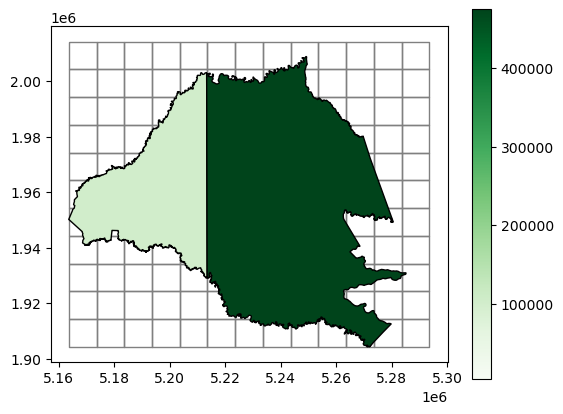

In [180]:
base = grid.plot(color='none', edgecolor='grey')
municipios_con_bosque.plot(
    ax=base, 
    column='area_bosque_ha', 
    edgecolor='black', 
    legend=True, 
    cmap='Greens'
);

Realizar un overlay entre los municipios y la cuadrícula previamente generada

In [181]:
# Esto genera una nueva capa con la superposición de la cuadrícula y los municipios con bosque
bosques_grid = municipios_con_bosque.overlay(grid)
bosques_grid = bosques_grid[['id', 'AREA_TOTAL', 'area_bosque_ha', 'geometry']]
bosques_grid

id     AREA_TOTAL  area_bosque_ha  \
0      7      33.861013     4039.894868   
1     19      33.861013     4039.894868   
2     31      33.861013     4039.894868   
3     43      33.861013     4039.894868   
4     56      33.861013     4039.894868   
..   ...            ...             ...   
102  138  486596.210986   474766.570711   
103  140  486596.210986   474766.570711   
104  141  486596.210986   474766.570711   
105  142  486596.210986   474766.570711   
106  152  486596.210986   474766.570711   

                                              geometry  
0    MULTIPOLYGON Z (((5173481.261 1942503.259 0, 5...  
1    MULTIPOLYGON Z (((5176124.564 1943040.518 0, 5...  
2    MULTIPOLYGON Z (((5183908.324 1942897.492 0, 5...  
3    MULTIPOLYGON Z (((5195124.746 1941180.78 0, 51...  
4    MULTIPOLYGON Z (((5206207.092 1933128.057 0, 5...  
..                                                 ...  
102  POLYGON Z ((5280576.661 1949238.381 0, 5280552...  
103  POLYGON Z ((5273657.133 1931893.389 0, 5273701...  
104  POLYGON Z ((5273631.222 1917153.977 0, 5273660...  
105  POLYGON Z ((5275229.049 1914169.064 0, 5275231...  
106  POLYGON Z ((5283644.295 1930884.14 0, 5283672....  

[107 rows x 4 columns]

Graficar el resultado de la cuadrícula con el área de bosque por celda

<Axes: >

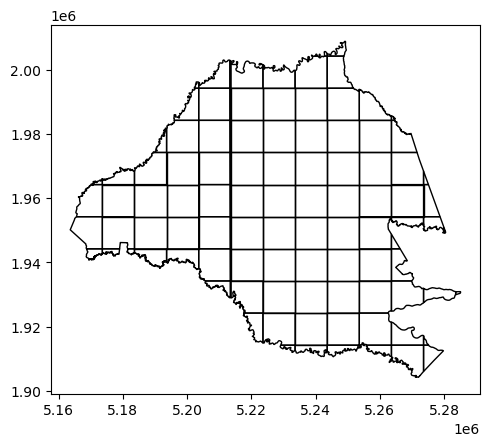

In [182]:
bosques_grid.plot(color='none', edgecolor='black')

Calcular el área de cada celda de la cuadrícula

In [183]:
bosques_grid['area_sub'] = bosques_grid.area
bosques_grid

id     AREA_TOTAL  area_bosque_ha  \
0      7      33.861013     4039.894868   
1     19      33.861013     4039.894868   
2     31      33.861013     4039.894868   
3     43      33.861013     4039.894868   
4     56      33.861013     4039.894868   
..   ...            ...             ...   
102  138  486596.210986   474766.570711   
103  140  486596.210986   474766.570711   
104  141  486596.210986   474766.570711   
105  142  486596.210986   474766.570711   
106  152  486596.210986   474766.570711   

                                              geometry      area_sub  
0    MULTIPOLYGON Z (((5173481.261 1942503.259 0, 5...  1.134528e+05  
1    MULTIPOLYGON Z (((5176124.564 1943040.518 0, 5...  8.074149e+04  
2    MULTIPOLYGON Z (((5183908.324 1942897.492 0, 5...  1.334230e+05  
3    MULTIPOLYGON Z (((5195124.746 1941180.78 0, 51...  1.043120e+04  
4    MULTIPOLYGON Z (((5206207.092 1933128.057 0, 5...  5.615691e+02  
..                                                 ...           ...  
102  POLYGON Z ((5280576.661 1949238.381 0, 5280552...  2.173035e+07  
103  POLYGON Z ((5273657.133 1931893.389 0, 5273701...  3.033893e+07  
104  POLYGON Z ((5273631.222 1917153.977 0, 5273660...  1.984779e+06  
105  POLYGON Z ((5275229.049 1914169.064 0, 5275231...  2.552910e+07  
106  POLYGON Z ((5283644.295 1930884.14 0, 5283672....  1.048331e+06  

[107 rows x 5 columns]

Graficar el área de las celdas de la cuadrícula con el área de bosque

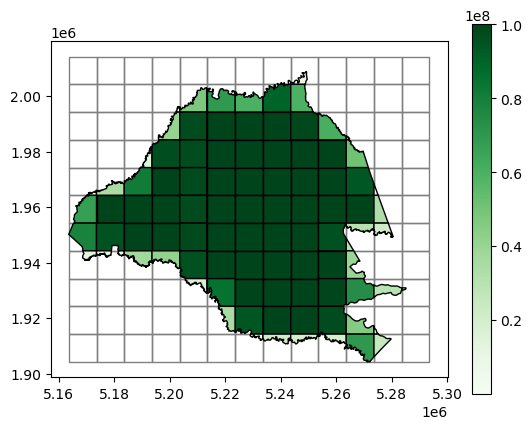

In [184]:
base = grid.plot(color='none', edgecolor='grey')
bosques_grid.plot(
    ax=base, 
    column='area_sub', 
    edgecolor='black',
    legend=True, 
    cmap='Greens'
);

Calcular la proporción de bosque dentro de cada celda de la cuadrícula y calcular el área de bosque para cada celda de la cuadrícula, tomando en cuenta la proporción de bosque.

In [185]:
bosques_grid['area_prop'] = bosques_grid['area_sub'] / bosques_grid['AREA_TOTAL']
bosques_grid['bosques'] = bosques_grid['area_bosque_ha'] * bosques_grid['area_prop']
bosques_grid

id     AREA_TOTAL  area_bosque_ha  \
0      7      33.861013     4039.894868   
1     19      33.861013     4039.894868   
2     31      33.861013     4039.894868   
3     43      33.861013     4039.894868   
4     56      33.861013     4039.894868   
..   ...            ...             ...   
102  138  486596.210986   474766.570711   
103  140  486596.210986   474766.570711   
104  141  486596.210986   474766.570711   
105  142  486596.210986   474766.570711   
106  152  486596.210986   474766.570711   

                                              geometry      area_sub  \
0    MULTIPOLYGON Z (((5173481.261 1942503.259 0, 5...  1.134528e+05   
1    MULTIPOLYGON Z (((5176124.564 1943040.518 0, 5...  8.074149e+04   
2    MULTIPOLYGON Z (((5183908.324 1942897.492 0, 5...  1.334230e+05   
3    MULTIPOLYGON Z (((5195124.746 1941180.78 0, 51...  1.043120e+04   
4    MULTIPOLYGON Z (((5206207.092 1933128.057 0, 5...  5.615691e+02   
..                                                 ...           ...   
102  POLYGON Z ((5280576.661 1949238.381 0, 5280552...  2.173035e+07   
103  POLYGON Z ((5273657.133 1931893.389 0, 5273701...  3.033893e+07   
104  POLYGON Z ((5273631.222 1917153.977 0, 5273660...  1.984779e+06   
105  POLYGON Z ((5275229.049 1914169.064 0, 5275231...  2.552910e+07   
106  POLYGON Z ((5283644.295 1930884.14 0, 5283672....  1.048331e+06   

       area_prop       bosques  
0    3350.544852  1.353585e+07  
1    2384.497255  9.633118e+06  
2    3940.314040  1.591845e+07  
3     308.059320  1.244527e+06  
4      16.584534  6.699977e+04  
..           ...           ...  
102    44.657872  2.120206e+07  
103    62.349290  2.960136e+07  
104     4.078903  1.936527e+06  
105    52.464655  2.490846e+07  
106     2.154416  1.022845e+06  

[107 rows x 7 columns]

Agrupar por el identificador de la celda (id) y sumar el área de bosque.

In [186]:
#Esto genera una tabla con la suma de áreas de bosque por celda de la cuadrícula
bosques_grid = bosques_grid.groupby('id')['bosques'].sum().reset_index()
grid = pd.merge(grid, bosques_grid[['id', 'bosques']], on='id', how='left')
# Unir la tabla con las celdas de la cuadrícula con las áreas de bosque calculadas
grid

geometry   id       bosques
0    POLYGON ((5163631 2014224, 5173631 2014224, 51...    0           NaN
1    POLYGON ((5163631 2004224, 5173631 2004224, 51...    1           NaN
2    POLYGON ((5163631 1994224, 5173631 1994224, 51...    2           NaN
3    POLYGON ((5163631 1984224, 5173631 1984224, 51...    3           NaN
4    POLYGON ((5163631 1974224, 5173631 1974224, 51...    4  1.655704e+06
..                                                 ...  ...           ...
138  POLYGON ((5283631 1954224, 5293631 1954224, 52...  150           NaN
139  POLYGON ((5283631 1944224, 5293631 1944224, 52...  151           NaN
140  POLYGON ((5283631 1934224, 5293631 1934224, 52...  152  1.022845e+06
141  POLYGON ((5283631 1924224, 5293631 1924224, 52...  153           NaN
142  POLYGON ((5283631 1914224, 5293631 1914224, 52...  154           NaN

[143 rows x 3 columns]

Graficar la cuadrícula con el área de bosque por celda.

<Axes: >

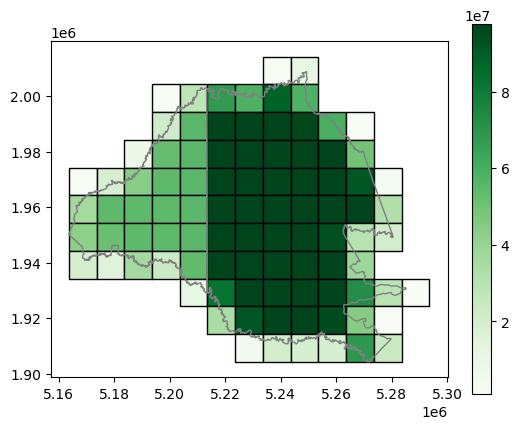

In [187]:
base = grid.plot(
    column='bosques', 
    edgecolor='black',
    legend=True, 
    cmap='Greens'
);
municipios_con_bosque.plot(ax=base, color='none', edgecolor='grey', legend=True)

##### 3. Compare the sum of the original attribute (e.g., population) in the project layer with the sum in the grid.

In [188]:
municipios_con_bosque['area_bosque_ha'].sum()

580309.8427646898

In [189]:
grid['bosques'].sum()/10000

580309.842765077

En este caso, la suma del atributo original (bosques) en la capa del proyecto (580309.8427646898) es prácticamente idéntica a la suma calculada en la cuadrícula (580309.842765077). Esto confirma que el procedimiento de interpolación ponderada por área preserva el valor total del atributo extensivo al redistribuirlo de manera proporcional a las áreas de intersección.

La diferencia insignificante entre ambos valores se debe probablemente a errores de redondeo numérico en los cálculos.

###### 1. What are incongruent layers, and how do they differ from congruent layers in spatial analysis?

*Incongruent layers*: Son capas espaciales que no tienen una alineación directa o coincidente en términos de sus límites geométricos. Esto significa que los polígonos, celdas o características de las capas no comparten la misma estructura espacial ni se superponen perfectamente. Un ejemplo es cuando una capa tiene polígonos de municipios y otra tiene una cuadrícula rasterizada.

*Congruent layers*: Son capas espaciales cuyos límites geométricos coinciden perfectamente o están alineados. En estas capas, las entidades espaciales comparten bordes y áreas comunes, lo que facilita la integración y el análisis conjunto.

La diferencia principal radica en que en las capas incongruentes, las entidades espaciales no coinciden, lo que genera desafíos para el análisis y la agregación de datos.

###### 2. Why is it important to address incongruence when aggregating spatial data?

Es crucial abordar la incongruencia en capas espaciales porque:

Preservación de atributos: En el caso de variables extensivas (como los bosques), la suma total debe preservarse después de la agregación o redistribución. Si no se considera la incongruencia, los valores totales pueden no coincidir.

Precisión del análisis: La incongruencia puede introducir errores al interpretar relaciones espaciales entre capas, ya que las áreas no coincidentes pueden dar lugar a datos incorrectos o sesgados.

Validez de los resultados: La falta de alineación espacial puede distorsionar las estadísticas resultantes (por ejemplo, densidades, promedios ponderados) al distribuir o calcular atributos sin considerar las proporciones geométricas reales.

###### 3. How does area-weighted interpolation help resolve issues caused by incongruence between layers?

La interpolación ponderada por área aborda la incongruencia al redistribuir los valores de una capa (por ejemplo, bosques) proporcionalmente al área de intersección con otra capa. Esto se realiza bajo las siguientes suposiciones:

Para variables extensivas (como bosque):

Los valores se distribuyen uniformemente dentro de los polígonos originales.
Las áreas de intersección entre capas reciben un valor proporcional al área del polígono original que cubren.

Para variables intensivas (como densidad de bosques):

Se calculan promedios ponderados basados en las áreas de intersección, preservando el valor medio en lugar de la suma total.
Esto asegura que los datos se ajusten de manera proporcional al espacio representado, resolviendo problemas de desajuste geométrico entre capas incongruentes.

###### 4. What are the limitations of using area-weighted interpolation with incongruent layers?

Aunque la interpolación ponderada por área es útil, tiene algunas limitaciones:

Suposición de uniformidad: La interpolación asume que los valores (como bosques o densidad) están distribuidos uniformemente dentro de cada polígono, lo cual puede no ser realista en áreas heterogéneas.

Errores en áreas pequeñas: Las intersecciones entre capas pueden ser muy pequeñas, lo que genera errores de redondeo o cálculos imprecisos en estas áreas.

Dependencia de la calidad de los datos: La precisión de los resultados depende de la calidad y la resolución de las capas espaciales originales. Capas con geometrías mal definidas o generalizadas pueden distorsionar los resultados.

Complejidad computacional: En capas grandes o con geometrías complejas, el cálculo de las intersecciones y el área ponderada puede ser computacionalmente costoso.

#### 5.2.6. Topological Relations

Perform at least one of the following operations:

##### 1. Find geometries that share a boundary with a specific feature.

###### Solución

Encontrar geometrías de puntos que comparten un borde con una característica específica, en este caso, los municipios. Se leen los archivos shapefile

In [190]:
municipios = gpd.read_file("Data\\Municipios.shp")
points = gpd.read_file("Data\\sample_points.shp")

Crear el gráfico base.

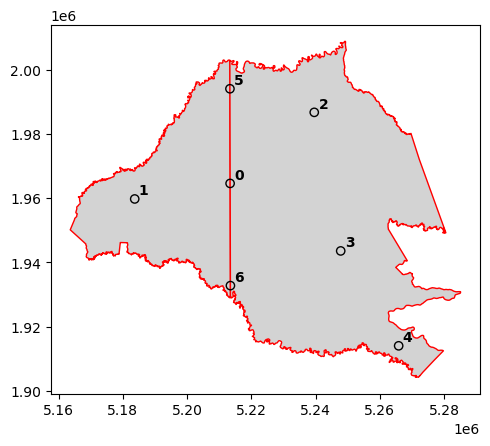

In [191]:
base = municipios.plot(color='lightgrey', edgecolor='red')
#Dibujar los puntos en el mapa
points.plot(ax=base, color='none', edgecolor='black')
# Iterar a través de los puntos y encontrar los que comparten borde con algún municipio
for i, point in enumerate(points.geometry):  # Asegúrate de acceder a la columna de geometrías
    base.annotate(
        i, xy=(point.x, point.y), 
        xytext=(3, 3), textcoords='offset points', weight='bold'
    )

Si el punto toca algún municipio, anotarlo:

In [192]:
points.touches(municipios.geometry.iloc[1])

0    False
1    False
2    False
3    False
4    False
5    False
6    False
dtype: bool

##### 2. Find geometries that cross others (e.g., roads crossing rivers).

###### Solución

Encontrar geometrías que crucen otras (por ejemplo, vías que cruzan municipios). 

In [193]:
# Leer los archivos shapefile
municipios = gpd.read_file("Data\\Municipios.shp")
vias = gpd.read_file("Data\\Via.shp")

<Axes: >

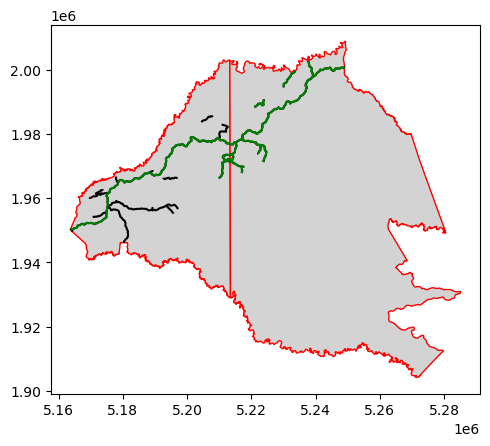

In [194]:
# Crear el gráfico base
base = municipios.plot(color='lightgrey', edgecolor='red')
# Dibujar las vías en el mapa
vias.plot(ax=base, color='black', edgecolor='black')

# Seleccionar las vías que cruzan el municipio en el índice 2
vias_selected = vias[vias.intersects(municipios.geometry.iloc[2])]
# Mostrar las vías seleccionadas en verde
vias_selected.plot(ax=base, color='green', edgecolor='black')

##### 3. Identify overlapping geometries (overlaps).

###### Solución

Se indentifican en el mapa los humedales en gris claro, mientras que aquellos que se superponen con los drenajes se mostrarán en azul claro.

<Axes: >

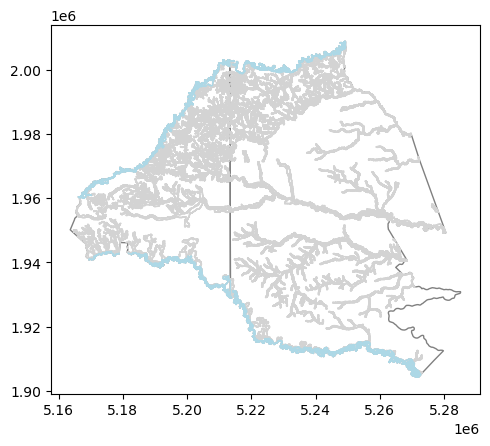

In [195]:
# Leer los archivos shapefile
Drenajes = gpd.read_file("Data\\Drenaje_Doble.shp")
Humedales = gpd.read_file("Data\\Humedales.shp")

# Identificar si los humedales se superponen con los drenajes
Humedales['intersecta_coberturas'] = Humedales.geometry.apply(
    lambda h: Drenajes.geometry.intersects(h).any()
)

# Filtrar solo los humedales que se superponen con los drenajes
humedales_intersectados = Humedales[Humedales['intersecta_coberturas']]

# Graficar los resultados
base = municipios.plot(color='None', edgecolor='gray')
Humedales.plot(ax=base, color='None', edgecolor='lightgray')
humedales_intersectados.plot(ax=base, color='None', edgecolor='lightblue')

##### 4. Use multiple predicates to assign categories. e.g. Classify land parcels as touching, within, or disjoint from protected areas.

C:\Users\marti\AppData\Local\Temp\ipykernel_20912\3138711255.py:8: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  Coberturas_touches.plot(ax=base, color='None', edgecolor='lightblue')


<Axes: >

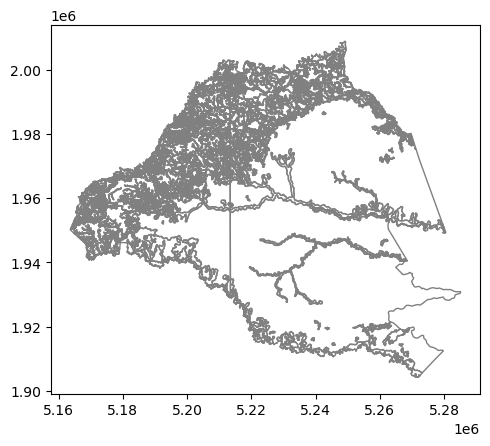

In [196]:
Drenajes = gpd.read_file("Data\\Drenaje_Doble.shp")
Coberturas = gpd.read_file("Data\\Coberturas.shp")

Coberturas_touches = Coberturas[Coberturas.touches(Drenajes.geometry.iloc[2])]

# Graficar los resultados
base = Coberturas.plot(color='None', edgecolor='gray')
Coberturas_touches.plot(ax=base, color='None', edgecolor='lightblue')

<Axes: >

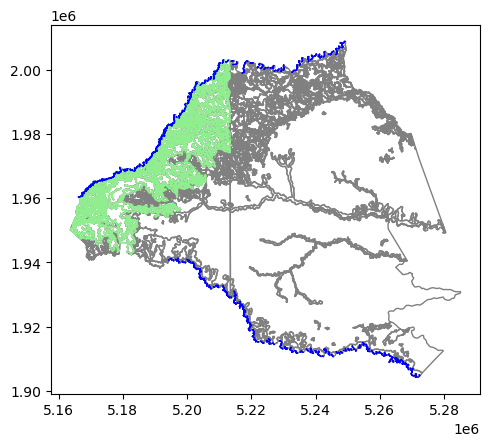

In [197]:
Drenajes = gpd.read_file("Data\\Drenaje_Doble.shp")
Coberturas = gpd.read_file("Data\\Coberturas.shp")

Coberturas_touches = Coberturas[Coberturas.intersects(Drenajes.geometry.iloc[0])]

# Graficar los resultados
base = Coberturas.plot(color='None', edgecolor='gray')
Coberturas_touches.plot(ax=base, color='None', edgecolor='lightgreen')
Drenajes.plot(ax=base, color ='Blue', edgecolor ='blue')

<Axes: >

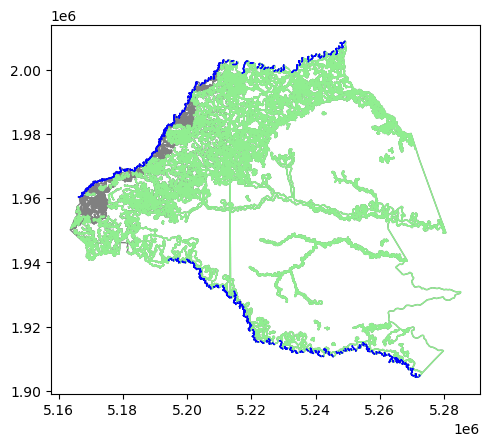

In [198]:
Drenajes = gpd.read_file("Data\\Drenaje_Doble.shp")
Coberturas = gpd.read_file("Data\\Coberturas.shp")

Coberturas_touches = Coberturas[Coberturas.disjoint(Drenajes.geometry.iloc[0])]

# Graficar los resultados
base = Coberturas.plot(color='None', edgecolor='gray')
Coberturas_touches.plot(ax=base, color='None', edgecolor='lightgreen')
Drenajes.plot(ax=base, color ='Blue', edgecolor ='blue')

#### 5.2.6. Spatial Operations on raster data

##### Clip a raster dataset (e.g., elevation, NDVI) to the extent of a vector layer such as administrative boundaries or study area.

('SR_B2_median', 'SR_B3_median', 'SR_B4_median', 'SR_B5_median', 'SR_B6_median', 'SR_B7_median', 'QA_PIXEL_median')


C:\Users\marti\AppData\Local\Temp\ipykernel_20912\897613607.py:17: RuntimeWarning: invalid value encountered in cast
  plt.imshow(falso_c.astype(np.uint8))


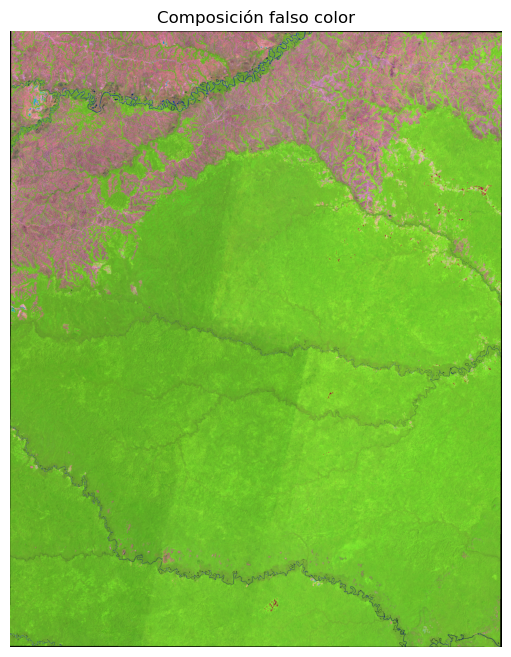

In [199]:
import rasterio
from rasterio.plot import show

##Primero se lee el raster y previsualzia
src_multi_rast = rasterio.open('Insumos_raster/Mosaico_ROI_2022_V4.tif')
print(src_multi_rast.descriptions)
landsat = src_multi_rast.read()
##Ajuste de imagen con parametros de visualzaición
red=landsat[4]*0.08  # Rojo
green=landsat[3]*0.06  # Verde
blue=landsat[2]*0.2   # Azul

falso_c = np.dstack((red, green, blue))  # Combinación de las bandas

# Visualizar la combinación
plt.figure(figsize=(12, 8))
plt.imshow(falso_c.astype(np.uint8))
plt.title("Composición falso color")
plt.axis("off")
plt.show()

In [200]:
#Se lee el shapefile con el ROI
roi = gpd.read_file("Data\\RI_UNUMA_Project.shp")

In [201]:
#se reproyecta la capa para que tenga la misma que el raster
roi = roi.to_crs(src_multi_rast.crs)

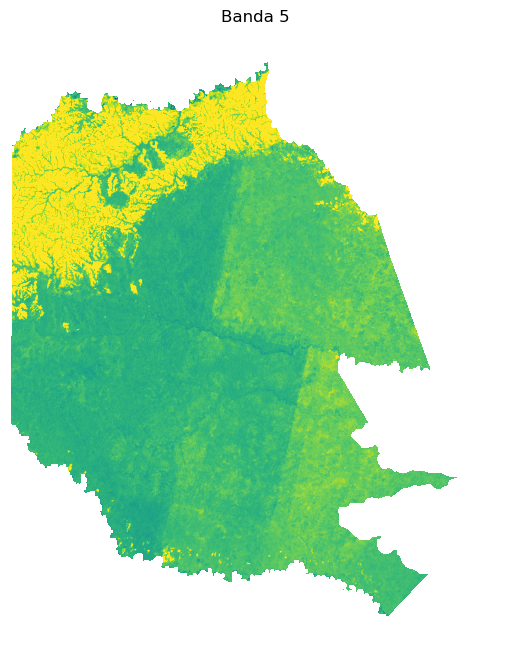

In [202]:
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

out_image_mask, out_transform_mask = rasterio.mask.mask(
    src_multi_rast, 
    roi.geometry, 
    crop=False, 
    nodata=9999
)

# Visualizar el raster recortado
plt.figure(figsize=(10, 8))
ndvi_data = np.ma.masked_equal(out_image_mask[4], 9999)  # Enmascarar nodata (9999)
plt.imshow(ndvi_data, vmin=0, vmax=2000)  # Ajustar escala
plt.title("Banda 5")
plt.axis("off")
plt.show()

##### Transform a raster dataset to the CRS of a vector layer or another spatial dataset.

In [203]:
import pyproj
import rasterio.warp

In [204]:
#VIusalziar el sistema de coordenadas del shape
roi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [205]:
#se crea una copia del raster original
import shutil
shutil.copy('Insumos_raster/Mosaico_ROI_2022_V4.tif', 'Insumos_raster/Mosaico_ROI_2022_V4_CRS.tif')

'Insumos_raster/Mosaico_ROI_2022_V4_CRS.tif'

In [206]:
#se visualizar el sistema de coordenadas que tiene
src_CRS = rasterio.open('Insumos_raster/Mosaico_ROI_2022_V4_CRS.tif', 'r+')
src_CRS.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [207]:
#Se le agrega el del shape
src_CRS.crs = 4686
src_CRS.close()

In [208]:
#Se observan los resultados
rasterio.open('Insumos_raster/Mosaico_ROI_2022_V4_CRS.tif').crs

CRS.from_wkt('GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4686"]]')

##### Calculate the mean or sum of raster values for each polygon in a vector dataset

<Axes: >

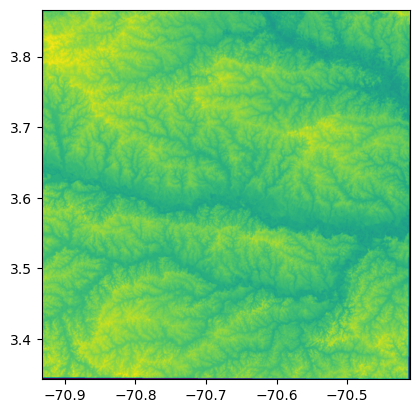

In [209]:
##Se lee el DEM
srtm = rasterio.open('Insumos_raster/SRTM_V2.tif')
fig, ax = plt.subplots()
rasterio.plot.show(srtm, ax=ax)

In [210]:
import geopandas as gpd
from rasterio.crs import CRS
import rasterstats

# Reproyectar el shapefile al sistema de coordenadas del raster
roi_red = gpd.read_file('Data\\Coberturas.shp')
with rasterio.open('Insumos_raster/SRTM_V2.tif') as srtm:
    roi_red = roi_red.to_crs(srtm.crs)
    
    result = rasterstats.zonal_stats(
    roi_red, 
    srtm.read(1), 
    nodata = srtm.nodata, 
    affine = srtm.transform, 
    stats = ['mean', 'min', 'max']
)
result


[{'mean': None, 'min': None, 'max': None},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'mean': None, 'min': None, 'max': None},
 {'mean': None, 'min': None, 'max': None},
 {'mean': None, 'min': None, 'max': None},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'mean': None, 'min': None, 'max': None},
 {'mean': None, 'min': None, 'max': None},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'mean': None, 'min': None, 'max': None},
 {'mean': None, 'min': None, 'max': None},
 {'mean': None, 'min': None, 'max': None},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'mean': None, 'min': None, 'max': None},
 {'min': 25.0, 'max': 25.0, 'mean': 25.0},
 {'mean': None, 'min': None, 'max': None},
 {'mean': None, 'min': None, 'max': None},
 {'mean': None, 'min': None, 'max': None},
 {'mean': N

##### Identify polygons with maximum or minimum values in the raster dataset.

In [211]:
# Agregar los resultados al GeoDataFrame
roi_red['valor_min'] = [stat['min'] for stat in result]
roi_red['valor_max'] = [stat['max'] for stat in result]

# Identificar el polígono con el valor máximo y mínimo
poligono_con_max = roi_red.loc[roi_red['valor_max'].idxmax()]
poligono_con_min = roi_red.loc[roi_red['valor_min'].idxmin()]

print("Polígono con el valor máximo del raster:")
print(poligono_con_max)

print("\nPolígono con el valor mínimo del raster:")
print(poligono_con_min)

Polígono con el valor máximo del raster:
OBJECTID                                               285661.0
codigo                                                    31111
leyenda            3.1.1.1.1. Bosque denso alto de tierra firme
insumo                       L8_558_20200127, L8_657_20200205p1
apoyo                                                      None
confiabili                                                   SI
cambio                                                        2
nivel_1                                                       3
nivel_2                                                      31
nivel_3                                                     311
nivel_4                                                    3111
nivel_5                                                   31111
nivel_6                                                    None
area_ha                                           141456.659826
ORIG_FID                                                    824

###### What challenges could arise when calculating zonal statistics for irregular or very small polygons?

Se identifico que aquellos poligonos que eran menores a el valor del pixel se marcaban como None 

##### Combine raster layers using mathematical operations to generate an index (e.g., suitability combining NDVI, slope, and distance to roads).

('SR_B2_median', 'SR_B3_median', 'SR_B4_median', 'SR_B5_median', 'SR_B6_median', 'SR_B7_median', 'QA_PIXEL_median')


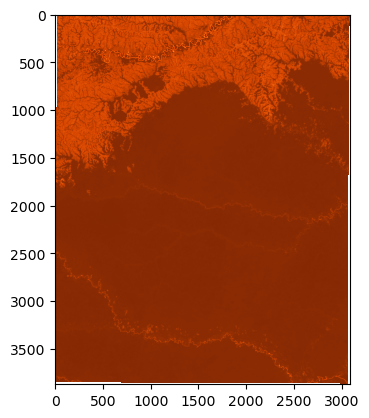

El NDVI ha sido guardado como 'ndvi.tif'


In [212]:
#CALCULO DE LA NDVI
print(src_multi_rast.descriptions)
landsat=src_multi_rast.read()
red=landsat[2]
nir=landsat[3]
ndvi=(nir-red)/(nir+red)
ndvi
rasterio.plot.show(ndvi, cmap='Oranges');

##Se guarda el archivo par ausarlo en futuros procesos 

with rasterio.open("Insumos_raster/Mosaico_ROI_2022_V4.tif") as src:
    affine = src.transform  # Transformación espacial
    crs = src.crs  # Sistema de referencia espacial (CRS)

# Guardar el NDVI como un nuevo raster
with rasterio.open(
    "ndvi.tif",  # Nombre del archivo de salida
    "w",  # Modo de escritura
    driver="GTiff",  # Formato del archivo
    height=ndvi.shape[0],  # Número de filas
    width=ndvi.shape[1],  # Número de columnas
    count=1,  # Número de bandas
    dtype="float32",  # Tipo de datos
    crs=crs,  # CRS (sistema de coordenadas)
    transform=affine,  # Transformación espacial
) as dst:
    dst.write(ndvi, 1)  # Escribir el NDVI en la banda 1

print("El NDVI ha sido guardado como 'ndvi.tif'")

##### How does resampling affect the accuracy and usefulness of your analysis?

El remuestreo puede afectar la precisión y utilidad del análisis al modificar la resolución espacial del raster. Al aumentar el tamaño del píxel, se pierde detalle y precisión, lo que puede dificultar la identificación de variaciones locales, mientras que al disminuirlo, se generan datos interpolados que pueden no reflejar la realidad. Métodos como vecino más cercano son ideales para datos categóricos, pero pueden producir bordes irregulares, mientras que bilineal o cúbico suavizan los datos continuos, aunque pueden distorsionar valores extremos. Por lo tanto, el remuestreo debe seleccionarse cuidadosamente para equilibrar precisión, detalle y eficiencia computacional, dependiendo del propósito del análisis.

##### Perform a smoothing operation using a moving window (e.g., 3x3 kernel) to reduce noise in a raster dataset.

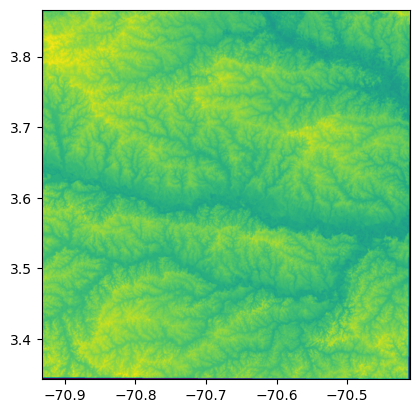

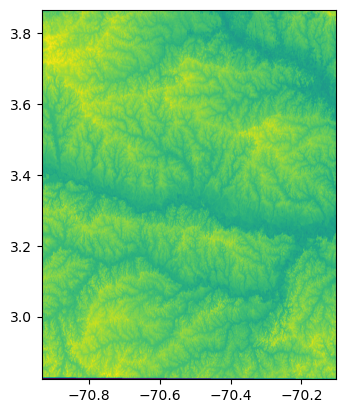

In [213]:
strm = rasterio.open('Insumos_raster/SRTM_V2.tif')

factor = 5
r2 = strm.read(1,
    out_shape=(
        int(strm.height * factor),
        int(strm.width * factor)
        ),
    resampling=rasterio.enums.Resampling.bilinear
)

new_transform2 = strm.transform * strm.transform.scale(
    (src.width / r2.shape[1]),
    (src.height / r2.shape[0])
)
new_transform2

rasterio.plot.show(strm.read(1), transform=strm.transform);
rasterio.plot.show(r2, transform=new_transform2);

##### How does the size of the focal window (e.g., 3x3 vs 5x5) affect the results 

Why might you use a focal mean (smoothing) versus a focal maximum (highlighting peaks)?

El tamaño de la ventana focal afecta directamente los resultados: una ventana pequeña (3x3) conserva más detalles espaciales y aplica un suavizado localizado, mientras que una ventana más grande (5x5) elimina más ruido pero puede difuminar o perder detalles importantes. La media focal (suavizado) es útil para reducir el ruido y generar transiciones más suaves, priorizando la continuidad espacial en análisis como modelos de elevación. En cambio, el máximo focal resalta características extremas, como picos en modelos de elevación o áreas con altas concentraciones en datos específicos, siendo útil para destacar puntos críticos.

##### Derive slope and aspect from a Digital Elevation Model (DEM) 

In [214]:
import os

In [215]:
os.system('gdaldem slope Insumos_raster/SRTM_V2.tif Insumos_raster/SRTM_SLOPE.tif')

0

In [216]:
path_in ="Insumos_raster/SRTM_V2.tif"
slope_out = "Insumos_raster/SRTM_SLOPE.tif"
aspect_out="Insumos_raster/SRTM_ASPECT.tif"
comando = f'gdaldem slope "{path_in}" "{slope_out}"'
os.system(comando)

0

In [217]:
os.system('gdaldem aspect Insumos_raster/SRTM_V2.tif Insumos_raster/SRTM_ASPECT.tif')
comando = f'gdaldem aspect "{path_in}" "{aspect_out}"'
os.system(comando)

0

Rango de valores en el archivo de aspecto:
Mínimo: 0.0
Máximo: 359.9342


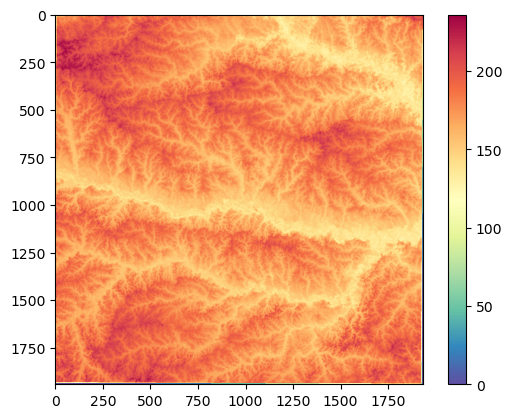

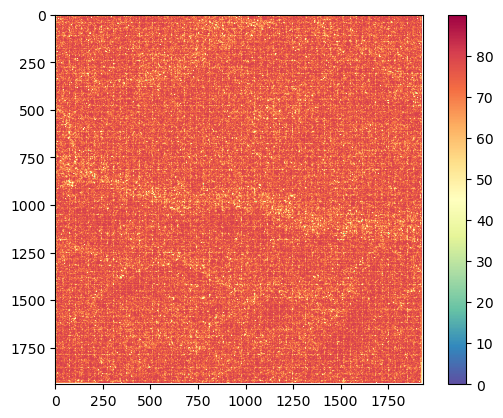

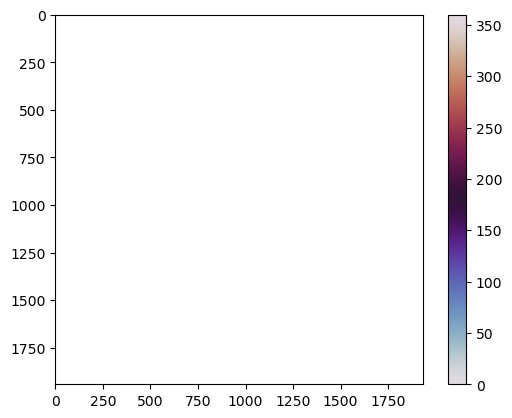

In [218]:
# Input DEM
src_srtm = rasterio.open(path_in)
srtm = src_srtm.read(1).astype(float)
srtm[srtm == src_srtm.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm, cmap='Spectral_r', ax=ax)
fig.colorbar(ax.imshow(srtm, cmap='Spectral_r'), ax=ax);
# Slope
src_srtm_slope = rasterio.open(slope_out)
srtm_slope = src_srtm_slope.read(1)
srtm_slope[srtm_slope == src_srtm_slope.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm_slope, cmap='Spectral_r', ax=ax)
fig.colorbar(ax.imshow(srtm_slope, cmap='Spectral_r'), ax=ax);
# Aspect
src_srtm_aspect = rasterio.open(aspect_out)
srtm_aspect = src_srtm_aspect.read(1)
srtm_aspect[srtm_aspect == src_srtm_aspect.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(src_srtm_aspect, cmap='twilight', ax=ax)
fig.colorbar(ax.imshow(srtm_aspect, cmap='twilight'), ax=ax);

# Verifica el rango de valores en el raster
print("Rango de valores en el archivo de aspecto:")
print("Mínimo:", np.nanmin(srtm_aspect))
print("Máximo:", np.nanmax(srtm_aspect))


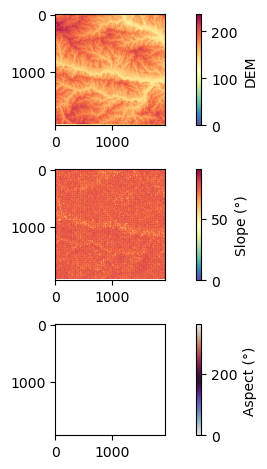

In [219]:
# Input DEM
src_srtm = rasterio.open(path_in)
srtm = src_srtm.read(1).astype(float)
srtm[srtm == src_srtm.nodata] = np.nan
fig, axes = plt.subplots(nrows=3, ncols=1)
# --- Subplot 1: DEM ---
rasterio.plot.show(src_srtm, cmap='Spectral_r', ax=axes[0])
im_dem = axes[0].imshow(srtm, cmap='Spectral_r')  
fig.colorbar(im_dem, ax=axes[0], label='DEM')

# --- Subplot 2: Slope ---
rasterio.plot.show(src_srtm_slope, cmap='Spectral_r', ax=axes[1])
im_slope = axes[1].imshow(srtm_slope, cmap='Spectral_r')
fig.colorbar(im_slope, ax=axes[1], label='Slope (°)')

# --- Subplot 3: Aspect ---
rasterio.plot.show(src_srtm_aspect, cmap='twilight', ax=axes[2])
im_aspect = axes[2].imshow(srtm_aspect, cmap='twilight')
fig.colorbar(im_aspect, ax=axes[2], label='Aspect (°)')

plt.tight_layout()
plt.show()

##### Mask a raster dataset using zones to extract only specific regions.

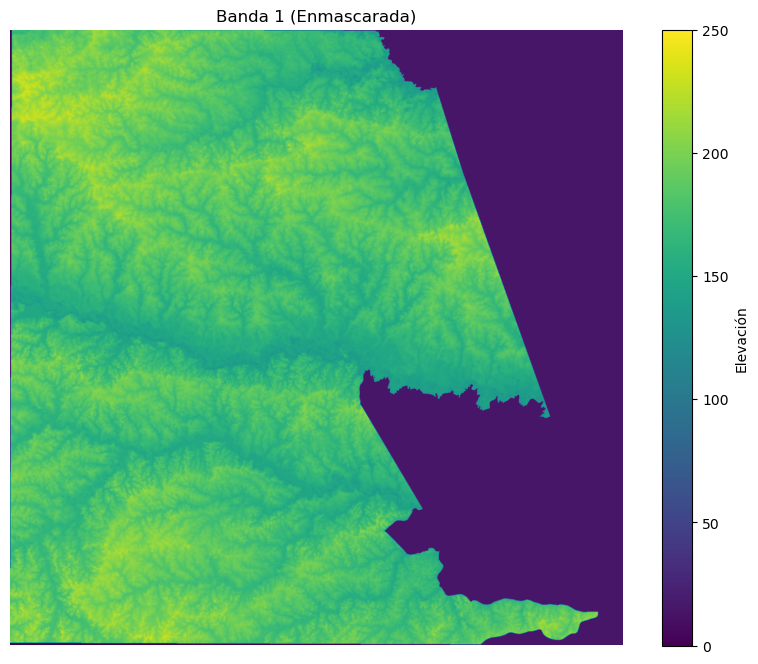

In [220]:
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Cargar el archivo raster 
ruta_raster = 'Insumos_raster/SRTM_V2.tif'
with rasterio.open(ruta_raster) as src:
    src_srtm = src.read(1)  # Leer la banda 1 del raster
    raster_crs = src.crs  # Obtener el CRS del raster
    
# Reproyectar la capa vectorial al CRS del raster
coberturas = coberturas.to_crs(raster_crs)

# Enmascarar el raster con la geometría de la capa vectorial
out_image_mask, out_transform_mask = rasterio.mask.mask(
    dataset=rasterio.open(ruta_raster),
    shapes=coberturas.geometry,
    crop=False,  
    nodata=9999  
)

# Visualizar el raster enmascarado
plt.figure(figsize=(10, 8))
src_srtm_masked = np.ma.masked_equal(out_image_mask[0], 9999)  # Enmascarar el valor NoData (9999)
plt.imshow(src_srtm_masked, vmin=0, vmax=250)  # Ajustar los límites de escala según tus datos
plt.title("Banda 1 (Enmascarada)")
plt.axis("off")
plt.colorbar(label="Elevación")
plt.show()


##### Gather two or more raster files with partial overlaps or adjacent coverage. 

In [221]:
import rasterio
from rasterio.merge import merge

# Lista de rutas de los rasters a fusionar
raster_files = [
    "Insumos_raster/SRTM_V2.tif",
    "Insumos_raster/SRTM_SLOPE.tif",
    "Insumos_raster/SRTM_ASPECT.tif"
]

# Leer los rasters y asegurarse de que tengan la misma resolución y tamaño
rasters = []
for file in raster_files:
    with rasterio.open(file) as src:
        rasters.append(src.read(1))  # Leer la primera banda

# Crear una matriz 3D donde cada capa corresponde a una banda
multi_band_array = np.stack(rasters, axis=0)

# Crear metadatos para el nuevo raster
with rasterio.open(raster_files[0]) as src:
    meta = src.meta.copy()

meta.update({
    "count": len(rasters),  # Número de bandas
    "dtype": "float32",     # Asegúrate de que el tipo de datos sea consistente
    "driver": "GTiff"       # Formato de salida
})

# Guardar el nuevo archivo raster con múltiples bandas
output_file = "Insumos_raster/SRTM_MOSAIC_MULTIBAND.tif"
with rasterio.open(output_file, "w", **meta) as dst:
    for i, band in enumerate(multi_band_array, start=1):
        dst.write(band, i)

print(f"Raster con múltiples bandas guardado como {output_file}")

Raster con múltiples bandas guardado como Insumos_raster/SRTM_MOSAIC_MULTIBAND.tif


In [222]:
with rasterio.open("Insumos_raster/SRTM_MOSAIC_MULTIBAND.tif") as src:
    print(f"Número de bandas: {src.count}")
    for i in range(1, src.count + 1):
        band = src.read(i)
        print(f"Banda {i} - Valor mínimo: {band.min()}, Valor máximo: {band.max()}")

Número de bandas: 3
Banda 1 - Valor mínimo: 0.0, Valor máximo: 236.0
Banda 2 - Valor mínimo: -9999.0, Valor máximo: 89.99986267089844
Banda 3 - Valor mínimo: -9999.0, Valor máximo: 359.9342041015625


##### What are the advantages of merging rasters into a single layer versus processing them separately?

Permite centralizar el almacenamiento de datos, lo que facilita su gestión y acceso. Este enfoque elimina la necesidad de manejar múltiples archivos separados, simplificando el flujo de trabajo y reduciendo el riesgo de errores o inconsistencias entre ellos. Además, acceder a bandas específicas desde un único archivo optimiza el procesamiento al disminuir las operaciones de entrada/salida y mejorar la eficiencia computacional. Esto resulta especialmente útil en análisis que requieren el uso simultáneo de múltiples capas, como el cálculo de índices o operaciones entre bandas.

##### Clip the merged raster to a specific area of interest (e.g., a study region) using vector data.

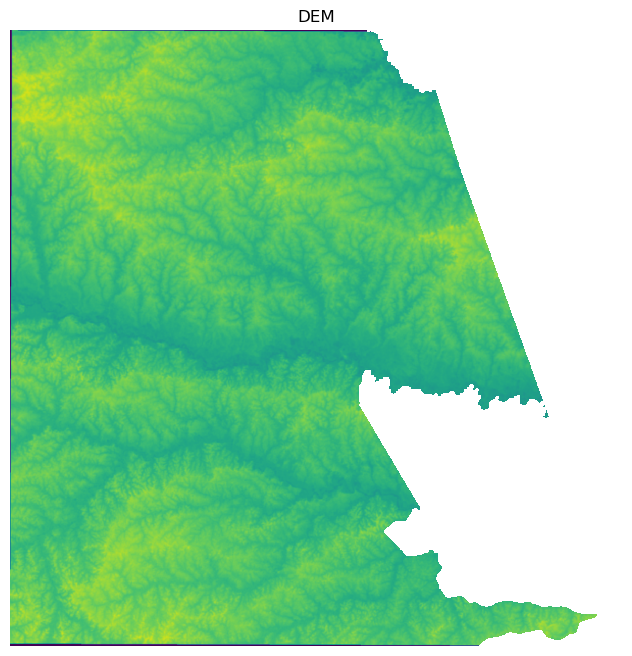

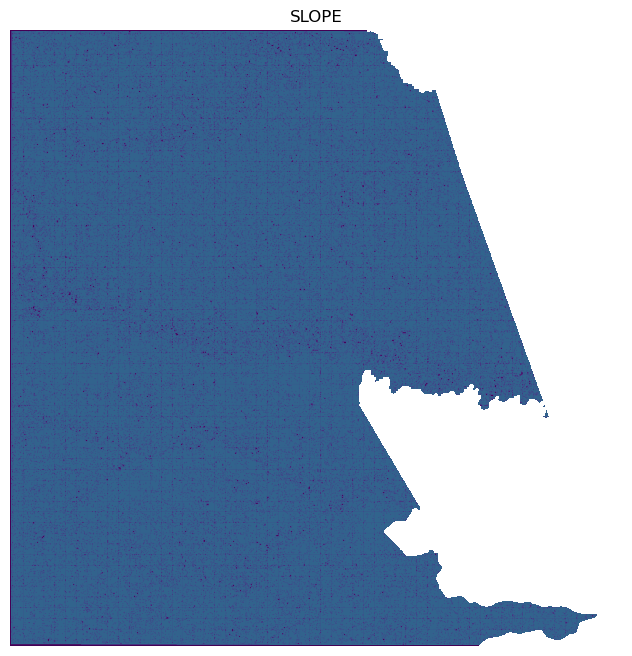

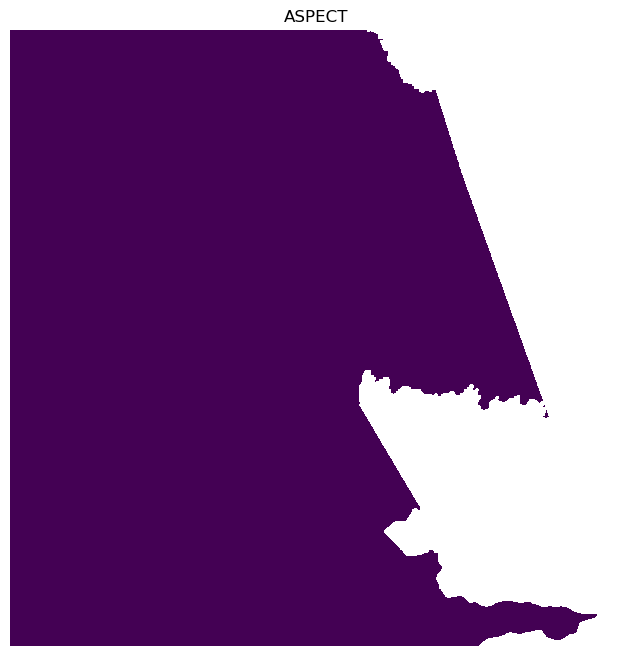

In [223]:
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Cargar el archivo raster 
raster_crs = rasterio.open('Insumos_raster/SRTM_MOSAIC_MULTIBAND.tif')

#se reproyecta la capa para que tenga la misma que el raster
roi = roi.to_crs(raster_crs.crs)

out_image_mask, out_transform_mask = rasterio.mask.mask(
    raster_crs, 
    roi.geometry, 
    crop=False, 
    nodata=9999
)

# Visualizar el raster recortado
plt.figure(figsize=(10, 8))
raster = np.ma.masked_equal(out_image_mask[0], 9999)  # Enmascarar nodata (9999)
plt.imshow(raster, vmin=0, vmax=250)  # Ajustar escala
plt.title("DEM")
plt.axis("off")
plt.show()

# Visualizar el raster recortado
plt.figure(figsize=(10, 8))
raster = np.ma.masked_equal(out_image_mask[1], 9999)  # Enmascarar nodata (9999)
plt.imshow(raster, vmin=0, vmax=250)  # Ajustar escala
plt.title("SLOPE")
plt.axis("off")
plt.show()

# Visualizar el raster recortado
plt.figure(figsize=(10, 8))
raster = np.ma.masked_equal(out_image_mask[2], 9999)  # Enmascarar nodata (9999)
plt.imshow(raster, vmin=0, vmax=359)  # Ajustar escala
plt.title("ASPECT")
plt.axis("off")
plt.show()


##### How do choices in preprocessing (e.g., clipping, reprojection, resampling) impact the final results of your analysis?
##### 
How would you prioritise different raster operations in a workflow where computational resources are limited?

Las elecciones en el preprocesamiento, como recorte, reproyección y remuestreo, impactan directamente en la precisión y relevancia del análisis final. Un recorte adecuado reduce datos irrelevantes y optimiza recursos, mientras que una reproyección mal ejecutada puede introducir errores geométricos, especialmente si no se utiliza un sistema adecuado como MAGNA-SIRGAS en Colombia. El remuestreo, por su parte, afecta la resolución y puede alterar los resultados según el método empleado. En un flujo de trabajo con recursos limitados, es clave priorizar la reducción temprana de datos (recorte), establecer un sistema de referencia adecuado desde el inicio y realizar remuestreos solo cuando sea estrictamente necesario, utilizando formatos y herramientas optimizadas para manejar grandes volúmenes de datos eficientemente.